In [2]:
import matplotlib.pyplot as plt
from matplotlib import pylab
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.ticker as ticker
from osgeo import gdal
import salem
import seaborn as sns
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
import statsmodels.api as stm
import math
from salem import *
import pwlf
from hydroeval import *
import xarray as xr
from sklearn.metrics import mean_squared_error as MSE
import fiona, rasterio
import geopandas as gpd
from rasterio.plot import show
import rasterio.plot as rplt
from rasterio.features import rasterize
from rasterstats import zonal_stats
import pickle
import warnings
warnings.filterwarnings("ignore")

def cm2inch(*tupl):  ### plots in cm ##frontiers 180 mm for full width, 85 mm half width (1 column) figures
    inch = 2.54
    if isinstance(tupl[0], tuple):
        return tuple(i/inch for i in tupl[0])
    else:
        return tuple(i/inch for i in tupl)
    
years = [2016, 2017, 2018]

sVSTAKE=1.10; sVOFFice=1.1; sVCoreg=2.0; sVRAND=1.5
sVsys=np.sqrt((sVOFFice**2)+(sVCoreg)**2)
sVZ=np.sqrt((sVsys**2)+((sVRAND)**2))
sVZ

2.7313000567495327

In [3]:
rho = pd.read_csv(fl_path + 'kokanee_rho_6.csv')

NameError: name 'fl_path' is not defined

Mean Vel. vz 4.79 2.7
4.7920294
2.6967874
Original vector layer projection:  {'init': 'epsg:2955'}
New vector layer projection (PROJ4):  +init=epsg:2955


(0, 'min')
(1, 'max')
(2, 'mean')
(3, 'count')
(4, 'sum')
(5, 'std')
(6, 'median')
(7, 'majority')
(8, 'minority')
(9, 'unique')
(10, 'range')
Original vector layer projection:  +init=epsg:2955
New vector layer projection (PROJ4):  +init=epsg:2955


(0, 'min')
(1, 'max')
(2, 'mean')
(3, 'count')
(4, 'sum')
(5, 'std')
(6, 'median')
(7, 'majority')
(8, 'minority')
(9, 'unique')
(10, 'range')
slope RLM: 0.00844987158924336
slope RLM: 0.007339409522348015
slope RLM: 0.007160961578207267
slope RLM: 0.006639622097746063
0.5614447951117141
0.5522259873993777
0.4496262281809177
Mean Vel. vz 4.79 2.97
4.7934384
2.971611
Original vector layer projection:  {'init': 'epsg:2955'}
New vector layer projection (PROJ4):  +init=epsg:2955


(0, 'min')
(1, 'max')
(2, 'mean')
(3, 'count')
(4, 'sum')
(5, 'std')
(6, 'median')
(7, 'majority')
(8, 'minority'

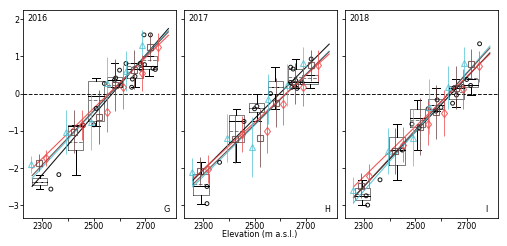

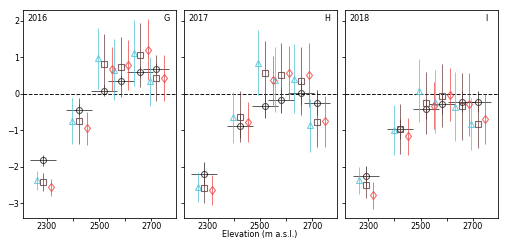

In [15]:
font = {'family' : 'Helvetica', 'weight' : 'normal',  'size'   : 8}
mfc='none'; mew=1.1; elw=0.9
plt.rc('font', **font)
pylab.rcParams['xtick.major.pad']='1.'; pylab.rcParams['ytick.major.pad']='1.'

fig1, ax1 = plt.subplots(1,3, sharex=True, sharey=True, figsize=(cm2inch(18, 8.25))) #obs. and flux gate SMB boxplot/errorbar plot
fig2, ax2 = plt.subplots(1,3, sharex=True, sharey=True, figsize=(cm2inch(18, 8.25))) ##mass conservation plot

count = 0

for yr in range(len(years)):
    # season
    balance = 'Ba'  # Bw or Ba (winter or annual)
    # rho_snow = 445. # 470 kg m-3 geodetic or 457 glaciological, or...take given years obs. value
    year = years[yr] # any of: 2016, 2017, 2018
    I = np.abs(year - 2016) # for selecting raster inputs

    gl = 0 # number to select glacier
    Glacier = ['Kokanee', 'Conrad']
    glacier = ['kokanee', 'conrad']
#   d = 20. # distance (meters) between flux gate points
    Dint = 0.85 #depth integrated velocity ratio, 1.0= all sliding
    sVSTAKE=1.10; sVOFFice=1.1; sVCoreg=2.0; sVRAND=1.5
    sVsys=np.sqrt((sVOFFice**2)+(sVCoreg)**2)
    sVZ=np.sqrt((sVsys**2)+((sVRAND)**2))
    
#     sVZ = 4.91  #velocity against stake measurements
#     spVZ = 0.216 
    sHopt = 0.078 ## ME:10.3 m,  MAE:0.223 (percent ratio)

    fl_path = '/home/pelto/Desktop/ice_flux/' + Glacier[gl] + '/'
    gpr_path = '/home/pelto/GIS/GPR/ComparisonData/'
    path = '/home/pelto/Desktop/lidar_cbt_analysis/kokanee/'
        
    VDIR = 'individual'  # 'average' or 'individual'
    firn = True
    
    if VDIR == 'individual':  
        
        vf_list = ['kokanee_vy_25m_2016.tif','kokanee_vy_25m_2017.tif','kokanee_vy_25m_2018.tif'] 
         #['img1_20160417__img1_20170521_vmap_5m_35px_spm2/', 'img1_20160417__img1_20170521_vmap_5m_35px_spm2/',
            #   'img1_20160417__img1_20170521_vmap_5m_35px_spm2/' ]#'img1_20150419__img2_20160417_vmap_5m_35px_spm2/'

        vdir = '/home/pelto/Desktop/velocity_mapping/kokanee/dem/3m/' 
        VX = vdir+ vf_list[I][:-15] + 'vx_25m_' +str(year)+ '.tif' 
        VY = vdir+ vf_list[I][:-15] + 'vy_25m_' +str(year)+ '.tif' 
        
#         VX = vdir+ vf[:-1] + '-F_vx.tif' 
#         VY = vdir+ vf[:-1] + '-F_vy.tif' 
       
    else:
        vdir = '/home/pelto/Desktop/velocity_mapping/kokanee/bedem/3m/old/'
        VX = vdir+ 'kokanee_all_bedem3m_vx_5m.tif'                    #kokanee_best_dem1m_5m_vx.tif' #   #'kokanee_all_bedem3m_vx_5m.tif'
        VY = '/home/pelto/Desktop/velocity_mapping/kokanee/dem/kokanee_all_dem1m_5m_vy.tif' #kokanee_best_pos_dem1m_5m_vy.tif '     #'kokanee_all_bedem3m_vy_5m.tif'
        VM = vdir+ 'kokanee_all_bedem3m_vm_5m_new.tif'     #'kokanee_all_bedem3m_vm_5m.tif'
    
    topo = '/home/pelto/Desktop/lidar_cbt_analysis/kokanee/20160913_kokanee_dem1_clip_slave.tif' 
    farinotti = gpr_path + 'RGI60-02/RGI60-02.00147_thickness.tif' #'RGI60-02.00147_thickness_srtm_corr.tif' #'RGI60-02/RGI60-02.00147'

    dhW_list = ['kokanee_2016_winter_dh_dt.tif', 'kokanee_2017_winter_dh_dt.tif', 'kokanee_2018_winter_dh_dt2.tif']
    dhA_list = ['kokanee_2016_2015_dh_dt.tif', 'kokanee_2017_2016_dh_dt_filled.tif','kokanee_2018_2017_dh_dt_21.tif', 'kokanee_2018_2015_dh_dt_21.tif']
    if balance == 'Bw':
        dh_r = path+ dhW_list[I]   #winter height change TIFF
    else:
        dh_r = path+  dhA_list[I] #Annual height change TIFF

    pts_file = fl_path + 'kokanee_gates_pts_6_20m_wgs84.shp'  ##must be WGS84 currently
    gates = fl_path+'Kok_flux_gates_6.shp'
    shpf = path + 'Kokanee/kok_all_glaciers_2015_dem.shp'   #GLIMS_BC/glims_all/all_glaciers_2016.shp' 
#     bins=fl_path+'kokanee_flux_bins.shp'
    if year==2016:
        bins=fl_path+'kokanee_flux_bins_6.shp'
    elif year==2017:
        bins=fl_path+'kokanee_flux_6bins_16.shp'
    else: 
        bins=fl_path+'kokanee_flux_6bins_17.shp'

    obs = pd.read_csv(fl_path+ 'Kokanee_bdot.csv')
    rho = pd.read_csv(fl_path + 'kokanee_rho_6.csv')  ## rho
    # open GeoTIFF as array
    
    vy = salem.open_xr_dataset(VY);vy = vy.to_array(name='vy')
    vx = salem.open_xr_dataset(VX);vx = vx.to_array(name='vx')
    msk = salem.open_xr_dataset(path + 'kokanee_2015_extent_5m.tif')
    msk_reproj = vy.salem.transform(msk); msk = msk_reproj.to_array(name='msk')
    topo ='/home/pelto/Desktop/lidar_cbt_analysis/kokanee/20181014_Kokanee_dem1_clip_slave.tif' 

    vz = vy
    vz.data = np.sqrt(vx.data**2 + vz.data**2 )
    vz.data[vz.data<0.01]=np.nan;# vz.data[vz.data>30.0]=vz.data[vz.data>30.0]*0.5 ##remove high erroneous values
    vz.data[msk.data!=1.0] = np.nan; 
    vz=xr.DataArray(vz.data, coords=vz.coords, name='vz')
    with open(fl_path+str(year)+'_vz.pkl', 'wb') as f:
        pickle.dump(vz[0].data, f)
    
    msk_all = salem.open_xr_dataset(fl_path + 'Kokanee_all_glaciers_2015_ice_msk_5m.tif')
    gpr = salem.open_xr_dataset(fl_path + 'gpr_outline_50_100m_5m.tif') #'gpr_outlines_all_25_25m_re5m.tif'
    farin = salem.open_xr_dataset(farinotti)

    H_opt = salem.open_xr_dataset(fl_path+ 'Kokanee_opt_thick_final.tif')#   'opt_thick251sw_MAE.tif'
    gates = salem.read_shapefile(gates)

    #reproject all images and ensure identical footprint for each 
    H_opt_reproj = vy.salem.transform(H_opt);H_opt = H_opt_reproj.to_array(name='H_opt')

    farin_reproj= vy.salem.transform(farin);farin = farin_reproj.to_array(name='farin')
    srtm_corr = fl_path + 'kokanee_SRTM_diff_29m_utm_5m.tif'
    srtm_corr = salem.open_xr_dataset(srtm_corr);srtm_corr_reproj = vy.salem.transform(srtm_corr)
    srtm_corr = srtm_corr_reproj.to_array(name='srtm_corr')
    srtm_corr.data[srtm_corr.data>10.0] = 0.0  ##remove positive anomalous values
    farin_corr = farin + srtm_corr
    farin_corr= farin_corr.rename('farin_corr')
    gpr_reproj = vy.salem.transform(gpr);gpr = gpr_reproj.to_array(name='gpr')

    gpr.data[gpr.data<0] = np.nan
    gpr.data[gpr.data<1.5] = 0.0   #not having any effect
#     vy.data[vy.data<0.0] = np.nan ## remove false velocity vectors (up glacier velocity)
#     VZ = np.sqrt(vx.data**2 + vy.data**2 )
    
    VZ_off_ice = vz.copy()
#     VZ[msk.data<1.0] = np.nan;VZ[VZ==0.0]=np.nan; VZ[VZ<0.1]=np.nan;
#     VZ_off_ice[msk.data>0.0] = np.nan
#     VZ_off_ice[VZ_off_ice==0.0] = np.nan

    dem = salem.open_xr_dataset(topo)
    dem_reproj = vy.salem.transform(dem)
    dem = dem_reproj.to_array(name='dem')
    dem.data[dem.data<1] = np.nan

    #     # map extent
    # grid = mercator_grid(center_ll=(-117.43, 51.238), extent=(4500, 4500)) ##zoomed out view
    # 487892.000 5509738.000 491232.000 5512358.000
    grid = vy.salem.grid  ##full view
    sm = Map(grid, countries=False)
    sm.set_lonlat_contours(interval=0)
    sm.set_scale_bar()
    sm.set_data(vz) #, label='m')
    #      Change the lon-lat countour setting
    sm.set_lonlat_contours(add_ytick_labels=True, interval=0.05, linewidths=0.75, linestyles='--', colors='0.25')
    off_ice_V = np.nanmean(VZ_off_ice)
    print('Mean Vel. vz', round(np.nanmean(vz),2), round(np.nanstd(vz),2))
    print(off_ice_V)
    print(np.nanstd(VZ_off_ice))
    gdf = salem.read_shapefile(shpf)
    sm.set_shapefile(gdf, linewidth=1)
    sm.set_shapefile(gates, linewidth=1.5, color='r')
#     sm.visualize()
#     plt.savefig(fl_path+ 'products/'+ glacier[gl] +str(year) +'ice_vel_gates.png', dpi=300)
#     plt.show()

    ## Functions for calculating zonal statistics over each flux gate bin

    # https://community.esri.com/groups/python-snippets/blog/2019/05/07/calculating-zonal-statistics-with-python-rasterstats
    # For loading shapefiles into geopandas dataframe

    def enum_items(source):
        print("\n")
        for ele in enumerate(source): 
            print(ele)

    def list_columns(df):
        field_list = list(df)
#         enum_items(field_list)
        return field_list

    def loadshp_as_gpd(shp):
        data_shp = gpd.read_file(shp)
        return data_shp

    # For loading feature classes into geopandas dataframe
    def loadfc_as_gpd(fgdb):
        layers = fiona.listlayers(fgdb)
        enum_items(layers)
        index = int(input("Which index to load? "))
        fcgpd = gpd.read_file(fgdb,layer=layers[index])
        return fcgpd

    # For re-projecting input vector layer to raster projection
    def reproject(fcgpd, raster):
        proj = raster.crs.to_proj4()
        print("Original vector layer projection: ", fcgpd.crs)
        reproj = fcgpd.to_crs(proj)
        print("New vector layer projection (PROJ4): ", reproj.crs)
#         fig, ax = plt.subplots(figsize=(10, 10))
#         rplt.show(raster, ax=ax)
#         reproj.plot(ax=ax, facecolor='none', edgecolor='red')
#         fig.show()
        return reproj

    def dissolve_gpd(df):
        field_list = list_columns(df)
        index = 1 #int(input("Dissolve by which field (index)? "))
        dgpd = df.dissolve(by=field_list[index])
        return dgpd

    # For selecting which raster statistics to calculate
    def stats_select():
        stats_list = stats_list = ['min', 'max', 'mean', 'count', 
                  'sum', 'std', 'median', 'majority', 
                  'minority', 'unique', 'range']
        enum_items(stats_list)
    #     indices = input("Enter raster statistics selections separated by space: ")
        indices='2 3 5 6'
        stats  = list(indices.split())
        out_stats = list()
        for i in stats:
            out_stats.append(stats_list[int(i)])
        return out_stats

    def get_zonal_stats(vector, raster, stats):
        # Run zonal statistics, store result in geopandas dataframe
        result = zonal_stats(vector, raster, stats=stats, geojson_out=True)
        geostats = gpd.GeoDataFrame.from_features(result)
        return geostats

    ###################### make an ice velocity quiver plot############################

    df = salem.read_shapefile(pts_file) 
    df_file = loadshp_as_gpd(pts_file)

    coords = np.array([p.xy for p in df.geometry]).squeeze()
    df['lon'] = coords[:, 0]
    df['lat'] = coords[:, 1]

    # ax.scatter(df.lon, df.lat, s=10, c='r' )#c='depth',cmap='viridis', s=10, ax=ax);
    xx, yy = salem.transform_proj(salem.wgs84, grid.proj, df['lon'].values, df['lat'].values)
    df['x'] = xx
    df['y'] = yy

    # shp_plt = reproject(df, VX)

    X, Y = np.meshgrid(vx.coords['x'],vx.coords['y'])
    U = vx.data[0]
    V = vy.data[0]

###########################################################################################
    vns = ['vx','vy','vz','gpr','H_opt','dem','farin_corr',]

    M = xr.merge([vx,vy,vz,gpr,H_opt,dem,farin_corr]) #dem

    for vn in vns:
        df[vn] = M[vn][0].interp(x=('z', df.x), y=('z', df.y))

    df_agg = df[['id', 'len', 'distance', 'angle', 'geometry', 'lon', 'lat']].copy()
    ii, jj = grid.transform(df['lon'], df['lat'], crs=salem.wgs84, nearest=True)
    df_agg['i'] = ii
    df_agg['j'] = jj
    # # We trick by creating an index of similar i's and j's
    # df_agg['ij'] = ['{:04d}_{:04d}'.format(i, j) for i, j in (vx.coords['x'], vx.coords['y'])]
    df_agg['ij'] = ['{:04d}_{:04d}'.format(i, j) for i, j in zip(ii, jj)]
    df_agg = df_agg.groupby('ij').mean()

    # Select
    for vn in vns:
    #     M_maksed = np.ma.masked_invalid(M[vn][0])
    #     df_agg[vn] = .interp(x=('z', df_agg.i), y=('z', df_agg.j))
        df_agg[vn] = M[vn][0].isel(x=('z', df_agg.i), y=('z', df_agg.j))  

    D = df_agg[['id', 'len', 'distance', 'angle', 'lon', 'lat', 'vx', 'vy','vz' ,'gpr', 'H_opt', 'dem', 'farin_corr']].copy()

    D['vzdir'] = np.arcsin(D.vx/D.vz) *180/math.pi #degrees from north

    ## add missing IPR data
    D.gpr[(D.id==0)&(D.distance==262.5)]=0.0
  
    depth=[12.5,22.7,30.95,37.2,41.4,63.2,59.6,51.5,40.4,26.0,8.5,0.0] 
    dist=[0.,20.,50.,80.,100.,1000.,1020,1050.,1080,1110.,1140.,1153.]
    for i in range(len(depth)):
        D.gpr[(D.id==1)&(D.distance==dist[i])]=depth[i] 
        
    dist=[0,20,40,60,80,100,130,160,180,210,240,260,290,320,340,360,380,400,420,440,460,480,560,590,2052]
    depth=[50.2,50.,49.9,49.7,49.5,49.3,49.,48.7,48.5,48.1,47.7,47.5,47.1,46.6,46.3,46.0,45.7,45.4,45.,44.7,44.3,44.,42.4,41.8,0.0]
    for i in range(len(depth)):
        D.gpr[(D.id==2)&(D.distance==dist[i])]=depth[i]
        
    dist=[620,640,660,680,710,740,760,790,820,840,860,880,900,920,940,960,980,1000,1020,1040,1060,1090,1120,1140,1170]
    depth=[55.2,54.2,53.4,52.7,51.9,51.4,51.1,51.0,51.1,51.4,51.7,52.2,52.8,53.5,54.3,55.2,56.3,57.5,58.7,60.1,61.6,64.1,66.9,68.9,72.0]
    
    for i in range(len(depth)):
        D.gpr[(D.id==3)&(D.distance==dist[i])]=depth[i]
        
    dist=[880,990,1020,1040,1060,1080,1100,1120,1150,1180,1200,1230,1260,1290,1320,1340,1370,1400,1420,1440,1460,1480,1500,1530,1560,1590,1620,1700.0,1720,1740,1760,1780,1800,1820]
    depth=[25.76923,39.53941,42.68357,44.63413,46.46823,48.2,49.8,51.27188,53.2807,55.02751,56.0465,57.35665,58.40479,59.19093,59.71506,59.91893,60.0064,59.83186,59.56995,59.19159,58.69678,58.08553,57.35783,56.04795,54.47607,52.64218,50.54629,37.43474,33.35523,29.06548,24.56549,19.85525,14.93477,9.804047]
    for i in range(len(depth)):
        D.gpr[(D.id==4)&(D.distance==dist[i])]=depth[i] 
    
    d=D[(D.id==4)&(D.distance>800)];dist=d.distance[np.isnan(d.gpr)].values;
    x=d.distance[np.logical_not(np.isnan(d.gpr))].values;y=d.gpr.values; y=y[np.logical_not(np.isnan(y))]
    coefficients = np.polyfit(x, y,5); poly = np.poly1d(coefficients); new_x = np.linspace(x[0], x[-1]);
    new_y = poly(new_x);fill=poly(dist);#plt.scatter(dist,fill,color='r');plt.plot(x, y, "o", new_x, new_y)
    for f in range(len(dist)):
        D.gpr[(D.id==4)&(D.distance==dist[f])]=fill[f]

    d=D[(D.id==4)&(D.distance<700)];dist=d.distance[np.isnan(d.gpr)].values;
    x=d.distance[np.logical_not(np.isnan(d.gpr))].values;y=d.gpr.values; y=y[np.logical_not(np.isnan(y))]
    coefficients = np.polyfit(x, y,7); poly = np.poly1d(coefficients); new_x = np.linspace(x[0], x[-1]);
    new_y = poly(new_x);fill=poly(dist)#;plt.scatter(dist,fill,color='r');plt.plot(x, y, "o", new_x, new_y)
    for f in range(len(dist)):
        D.gpr[(D.id==4)&(D.distance==dist[f])]=fill[f]
    
    if year==2016: 
        with open(fl_path + glacier[0]+'_df_agg.pkl', 'wb') as f:
            pickle.dump(D, f)
    #multiply velocity vector by cosine of angle between vector and flux gate (line or line segment)
    D['vfg'] = np.abs(D.vz) # * np.cos((D.vzdir-(D.angle-90.))*(math.pi/180.))) #velocity normal to gate per slice
    for i in range(len((D))):   #D.id.nunique()):
        if np.isnan(D.vfg[i])==True:
            G=D.id[i]
            V=np.nanmean(D.vfg[D.id==G]) 
            D.vfg[i]=V     
    with open(fl_path + str(year)+'_Dvfg.pkl', 'wb') as f:
        pickle.dump(D.vfg.values, f)
    
    D.sort_values(by=['distance','id'],ascending=[True,True], inplace=True) 
    
    for n in range(D.id.nunique()):

        for c in range(len(D.id[D.id==n])): #.count()-1)#range(D.id[D.id==n].count()-1):
            idx=D[(D.id==n)&(D.distance==D[D.id==n].distance[c])].index

            if c==0:  ## first point in line
                L= D.distance[D.id==n][c+1] - D.distance[D.id==n][c]
                G= L * D.H_opt[D.id==n][c+1]*0.5;J= L * D.farin_corr[D.id==n][c+1]*0.5 #area of triangle
                 
            elif c==1: #second point from start
                L= (D.distance[D.id==n][c+1] - D.distance[D.id==n][c])/2
                G= L * D.H_opt[D.id==n][c]; J= L * D.farin_corr[D.id==n][c]
                 
            elif c==len(D.id[D.id==n])-2: #second to last point
                L= (D.distance[D.id==n][c] - D.distance[D.id==n][c-1])/2 
                G= L * D.H_opt[D.id==n]; J= L * D.farin_corr[D.id==n]
                
            elif c==len(D.id[D.id==n])-1:  #last point in line
                L= (D.distance[D.id==n][c] - D.distance[D.id==n][c-1])
                G= L * D.H_opt[D.id==n][c-1]*0.5; J= L * D.farin_corr[D.id==n][c-1]*0.5 #area of triangle
                
            else:
                L=(((D.distance[D.id==n][c+1]-D.distance[D.id==n][c])/2) + ((D.distance[D.id==n][c] -
                        D.distance[D.id==n][c-1])/2))
                G=L* D.H_opt[D.id==n][c] ; J=L* D.farin_corr[D.id==n][c]  
                
            D.loc[idx,'A_Hopt']= G;D.loc[idx,'A_farin']= J; D.loc[idx,'Len_mod']= L     
    D_all=D.copy() 
        
        
    D['Qopt'] = D.A_Hopt * (D.vfg) * Dint;D['Qfarin'] = D.A_farin * (D.vfg) * Dint 

    ### Uncertainties
    D['sQout'] = np.sqrt((sVZ * D.A_Hopt)**2 + ((D.vfg*Dint) * D.Len_mod * (sHopt*D.H_opt))**2)
    D['sQout_low'] = np.sqrt((sVZ * D.A_Hopt)**2 + ((D.vfg*0.80) * D.Len_mod * (sHopt*D.H_opt))**2)
    D['sQout_high'] = np.sqrt((sVZ * D.A_Hopt)**2 + ((D.vfg*1.00) * D.Len_mod * (sHopt*D.H_opt))**2)
    D['sQoutF'] = np.sqrt((sVZ * D.A_farin)**2 + ((D.vfg*Dint) * D.Len_mod * (sHopt*D.farin_corr))**2)

    Q_out= [0.,]; cr_area = [0.,];gate_width=[0.,]
    vzdir = [0.,]; sQout= [0.,];sQout_low= [0.,];sQout_high= [0.,];vfg_all=[];gate_elev=[];v_gate_mean=[];Len_mod=[0.,]
    DV= D.copy(); DV = DV.dropna(subset=['vfg'])
    
    for n in range(D.id.nunique()):
        vfg_all.append(DV.vfg[DV.id==n])
        gate_elev.append(D.dem[D.id==n].mean())   

    for n in range(D.id.nunique()+1):
            Q_out.append(D.Qopt[D.id==n].sum()) 
            cr_area.append(D.A_Hopt[D.id==n].sum())
            vzdir.append(D.vzdir[D.id==n].mean());gate_width.append(D.len[D.id==n].max())
            sQout.append(D.sQout[D.id==n].sum());sQout_low.append(D.sQout_low[D.id==n].sum()); sQout_high.append(D.sQout_high[D.id==n].sum())  
            v_gate_mean.append(np.nanmean(D.vfg[D.id==n]));Len_mod.append(D.Len_mod[D.id==n].sum())
    Q_in = [Q_out[1:]]; sQin = [sQout[1:]+ [0.0]]; Q_in = np.squeeze(Q_in);sQin = np.squeeze(sQin)
    sQin_low = [sQout_low[1:]+ [0.0]];sQin_high = [sQout_high[1:]+ [0.0]]    
    sQin = np.squeeze(sQin);sQin_low = np.squeeze(sQin_low);sQin_high = np.squeeze(sQin_high)
    
    Q_outF= [0.,] #flux out per gate
    cr_areaF = [0.,]; sQoutF = [0.,]
    for n in range(D.id.nunique()+1):
            Q_outF.append(D.Qfarin[D.id==n].sum()) 
            cr_areaF.append(D.A_farin[D.id==n].sum()) 
            sQoutF.append(D.sQoutF[D.id==n].sum())

    Q_inF = [Q_outF[1:]] #flux in per bin
    Q_inF = np.squeeze(Q_inF)
    sQinF = [sQoutF[1:]+ [0.0]]
    sQinF = np.squeeze(sQinF)

    FG = pd.DataFrame(list(zip(Q_out, Q_in, cr_area, sQout, sQout_low, sQout_high, sQin, sQin_low, sQin_high, Q_outF, Q_inF, sQoutF, sQinF, cr_areaF, vzdir,v_gate_mean,Len_mod,gate_width)), 
            columns=['Q_out', 'Q_in', 'cr_area', 'sQout', 'sQout_low', 'sQout_high', 'sQin', 'sQin_low', 'sQin_high', 'Q_outF', 'Q_inF','sQoutF', 'sQinF', 'cr_areaF', 'vzdir','v_gate_mean','Len_mod','gate_width']) 

    FG_df = FG.copy()
    dem_r = topo
    if VDIR == 'individual':
        vel_r = VX  #[:-1] + '-F_vm.tif'
    else:
        vel_r = VX[:-8] + 'm_5m.tif'
    shp = loadshp_as_gpd(bins)

    rasters = [dh_r, dem_r]#, vel_r]
    names = ['dh','dem']#,'vm']
    for i in range(len(rasters)):
        raster = rasters[i]
        rst = rasterio.open(raster)
        shp = reproject(shp, rst) #shp is in correct projection, trying anyway for calculation
        # dhdt= vx.salem.transform(dhdt)
        name = names[i]
    #     shp_vec = dissolve_gpd(shp)  ## only if more columns exist
        stats = stats_select()  #'['min', 'max', 'mean', 'count', 'sum', 'std', 'median', 'majority', 'minority', 'unique', 'range']
        ZS = (get_zonal_stats(shp, raster, stats))
        ZS.drop(['geometry'], axis=1, inplace=True)
        ZS.rename(columns={"mean": name+"_mean", "median":name+"_med","min":name+"_min","max":name+"_max","std": name+"_std", "count":name+"_count"}, inplace=True)
        ZS.sort_values(by=['bin'],ascending=True, inplace=True)
        ZS.set_index('bin', inplace=True)
        FG_df =  pd.concat([FG_df, ZS], axis=1)
    tb = 5 #top full bin
    FG_df.loc[tb, 'Q_in'] = 0.0 #FG_df.Q_out[tb+1] + FG_df.Q_out[tb+2] #flux in top full bin
    FG_df.loc[tb, 'Q_inF'] = 0.0 # FG_df.Q_outF[tb+1] + FG_df.Q_outF[tb+2] #flux in top full bin
#     FG_df.loc[tb+1, 'Q_in'] = 0.0
#     FG_df.loc[tb+1, 'Q_inF'] = 0.0
#     FG_df.loc[tb+2, 'Q_in'] = 0.0 #flux in bin 6
#     FG_df.loc[tb+2, 'Q_inF'] = 0.0 #flux in bin 6
    
    FG_df['vfg'] = FG_df.Q_out / FG_df.cr_area #net velocity per gate
    FG_df['vfg_F'] = FG_df.Q_outF / FG_df.cr_area    

    FG_df['bin']=np.arange(0,len(range(D.id.nunique()+1)),1)
    # FG_df['sQnet_opt'] = np.sqrt(FG_df.sQopt**2 + FG_df.sQin**2)

    FG_df['spQout'] = FG_df.sQout / FG_df.Q_out * 100. #%err on flux
    FG_df['spQin'] = FG_df.sQin / FG_df.Q_in * 100. #%err on flux
    FG_df['spQoutF'] = FG_df.sQoutF / FG_df.Q_outF * 100. #%err on flux
    FG_df['spQinF'] = FG_df.sQinF / FG_df.Q_inF * 100. #%err on flux

    ### import data per bin: height change, elevation, surface area, obs.SMB etc. 
    rho.sort_values(by='bin',ascending=True, inplace=True) # sort by bin
    rho.set_index('bin', inplace=True) # set bin as index for sorting
    FG_df =  pd.concat([FG_df, rho], axis=1)

    WR= np.array(FG_df.dem_count[1:])
    WR= np.append(WR,[0])

    FG_df['Q_net'] = FG_df.Q_in - FG_df.Q_out  #net flux per gate
#     FG_df.loc[4, 'Q_net'] = FG_df.Q_out[5] + FG_df.Q_out[6] - FG_df.Q_out[4] #should be covered by updated Q_in
    FG_df['Q_netA']= FG_df.Q_net / FG_df.dem_count

    FG_df['Q_netF'] = FG_df.Q_inF - FG_df.Q_outF  #net flux per gate
    FG_df['Q_netAF']= FG_df.Q_netF / FG_df.dem_count

    FG_df['area_Qin']= WR
    FG_df['sQoptA'] = FG_df.sQout / FG_df.dem_count
    FG_df['sQoptA_low'] = FG_df.sQout_low / FG_df.dem_count;FG_df['sQoptA_high'] = FG_df.sQout_high / FG_df.dem_count    
    FG_df['sQ_inA'] = FG_df.sQin / (FG_df.area_Qin+0.001)
    FG_df['sQ_inA_low'] = FG_df.sQin_low / (FG_df.area_Qin+0.001);FG_df['sQ_inA_high'] = FG_df.sQin_high / (FG_df.area_Qin+0.001)    
    FG_df['sQnetA_opt'] = np.sqrt(FG_df.sQoptA**2 + FG_df.sQ_inA**2)
    FG_df['sQnetA_opt_low'] = np.sqrt(FG_df.sQoptA_low**2 + FG_df.sQ_inA_low**2);FG_df['sQnetA_opt_high'] = np.sqrt(FG_df.sQoptA_high**2 + FG_df.sQ_inA_high**2)
    FG_df['sQoutFA'] = FG_df.sQoutF / FG_df.dem_count
    FG_df['sQ_inFA'] = FG_df.sQinF / (FG_df.area_Qin+0.001)
    FG_df['sQnetFA'] = np.sqrt(FG_df.sQoutFA**2 + FG_df.sQ_inFA**2)

    ##calculate height change due to mass balance for highest bins considering firn compaction
    if firn == False:
        FG_df.Vfirn = 0.0
    FG_df['b_fg_h'] = FG_df.dh_mean - FG_df.Q_netA + FG_df.Vfirn
    FG_df['b_fg_hF'] = FG_df.dh_mean - FG_df.Q_netAF + FG_df.Vfirn

    for r in range(len(FG_df.dem_count)):  ## set density of mass change to density of snow if Bn>0.0 (Pelto et al. (2019))
        if FG_df.b_fg_h[r] < 0.0:
            FG_df['rho_%s'%year][r]=FG_df['rho_%s'%year][r]
        else:
            FG_df['rho_%s'%year][r]=572.

    # FG_df['b_fg_h'] = FG_df.dh_mean - FG_df.Q_netA
    FG_df['rho_snow'] = (FG_df.dem_mean*(-0.0766))+630.377  #*-0.11255+743.22)
    if balance == 'Bw':
    #     FG_df['b_fg_we'] = rho_snow/1000. * FG_df.b_fg_h
        FG_df['b_fg_we'] = FG_df.rho_snow/1000 * FG_df.b_fg_h
    else:
        FG_df['b_fg_we'] = FG_df['rho_%s'%year]/1000. * FG_df.b_fg_h

    if balance == 'Bw':
    #     FG_df['b_fg_weF'] = rho_snow/1000. * FG_df.b_fg_hF
        FG_df['b_fg_weF'] = FG_df.rho_snow/1000 * FG_df.b_fg_hF
    else:
        FG_df['b_fg_weF'] = FG_df['rho_%s'%year]/1000. * FG_df.b_fg_hF

    ### Uncertainties
    if I==0:
        sDHdt = 0.15 #NMAD coreg values            #0.04 #m Bias dh from Pelto et al. 2019
    if I==1:
        sDHdt = 0.34
    elif I==2:
        sDHdt = 0.28
    
    #sDHdt = 0.21 #    s_h_dem 0.21m,    0.04 m Bias dh from Pelto et al. 2019 
    sVfirn = 0.10
    sRHO = 0.10 # percent uncertainty in density

    # if FG_df.Vfirn > 0.00:
    # FG_df['sDH_opt'] = np.sqrt(sDHdt**2 + (FG_df.sQnet_opt / FG_df.dem_count)**2 + (FG_df.Vfirn*sVfirn)**2) #FG_df.sQnet_opt / FG_df.dem_count
    FG_df['sDH_opt'] = np.sqrt(sDHdt**2 + (FG_df.sQnetA_opt)**2 + (FG_df.Vfirn*sVfirn)**2)
    FG_df['sBwe_opt'] = np.sqrt((FG_df.sDH_opt * (FG_df['rho_%s'%year]/1000.))**2+
                   (FG_df.dh_mean * (FG_df['rho_%s'%year]/1000.*sRHO))**2)

    FG_df['sDH_F'] = np.sqrt(sDHdt**2 + (FG_df.sQnetFA)**2 + (FG_df.Vfirn*sVfirn)**2)
    FG_df['sBwe_F'] = np.sqrt((FG_df.sDH_F * (FG_df['rho_%s'%year]/1000.))**2+
                   (FG_df.dh_mean * (FG_df['rho_%s'%year]/1000.*sRHO))**2)

    D['Agpr']=np.NaN
    pidx=D[(D.id==2)&(D.distance==0.0)].index ; D.loc[D.index == pidx[0],'gpr']=40.0 ## assign a value to first point on gate 2
    D = D.dropna(subset=['gpr']);D.sort_values(by=['distance','id'],ascending=[True,True], inplace=True) 
    
    for n in range(D.id.nunique()):

        for c in range(len(D.id[D.id==n])): #.count()-1)#range(D.id[D.id==n].count()-1):
            idx=D[(D.id==n)&(D.distance==D[D.id==n].distance[c])].index

            if c==0:  ## first point in line
                L= D.distance[D.id==n][c+1] - D.distance[D.id==n][c]
                G= L * D.gpr[D.id==n][c+1]*0.5;J= L * D.farin_corr[D.id==n][c+1]*0.5 #area of triangle
                 
            elif c==1: #second point from start
                L= (D.distance[D.id==n][c+1] - D.distance[D.id==n][c])/2
                G= L * D.gpr[D.id==n][c]; J= L * D.farin_corr[D.id==n][c]
                 
            elif c==len(D.id[D.id==n])-2: #second to last point
                L= (D.distance[D.id==n][c] - D.distance[D.id==n][c-1])/2 
                G= L * D.gpr[D.id==n]; J= L * D.farin_corr[D.id==n]
                
            elif c==len(D.id[D.id==n])-1:  #last point in line
                L= (D.distance[D.id==n][c] - D.distance[D.id==n][c-1])
                G= L * D.gpr[D.id==n][c-1]*0.5; J= L * D.farin_corr[D.id==n][c-1]*0.5 #area of triangle
                
            else:
                L=(((D.distance[D.id==n][c+1]-D.distance[D.id==n][c])/2) + ((D.distance[D.id==n][c] -
                        D.distance[D.id==n][c-1])/2))
                G=L* D.gpr[D.id==n][c] ; J=L* D.farin_corr[D.id==n][c]  
                
            D.loc[idx,'Agpr']= G; D.loc[idx,'Len_gpr']= L 

    #calculate flux out using GPR thicknesses
    sGPR = 0.0516 #gpr error %
    D['sInterp_gpr'] = np.nan
    for n in range(len(D.Len_gpr)):
        if D.Len_gpr[n] > 50.:
            D.sInterp_gpr[n] = D.gpr[n] * 0.10  
        else: 
            D.sInterp_gpr[n] = 0.0
    sH_gpr = np.sqrt(D.sInterp_gpr**2+ (D.gpr*sGPR)**2)
    D['Qo_gpr'] = D.Agpr * (D.vfg) * Dint   #* 0.9 #- off_ice_V+sVZ
    D['sQo_gpr'] =  np.sqrt(((sVZ) * (D.gpr) * D.Len_gpr)**2 + ((D.vfg*Dint) * D.Len_gpr * (sH_gpr))**2)

    # D['sQo_gpr'] = np.sqrt((sVZ**2) * ((D.gpr**2 + (sH_gpr)**2) * (D.vfg*Dint)**2) * d**2)

    # D.to_csv(fl_path+'kok_16.csv') #'kokanee_gpr_fluxG_pts.csv')
    # for i in range(len(range(D.id.nunique()+1))):
    #     print(i, D.Agpr[D.id==i].mean())

    Qo_gpr = [0.,];cr_area_gpr = [0.,] ; vzdir_gpr = [0.,]; sQo_gpr= [0.,]; Len_gpr=[0.,]
    
    for n in range(D.id.nunique()):
            Qo_gpr.append(D.Qo_gpr[D.id==n].sum()) 
            cr_area_gpr.append(D.Agpr[D.id==n].sum())
            vzdir_gpr.append(D.vzdir[D.id==n].mean())
            sQo_gpr.append(D.sQo_gpr[D.id==n].sum())
            Len_gpr.append(D.Len_gpr[D.id==n].sum())
    Qin_gpr = [Qo_gpr[1:]+ [0.0]] #flux in per bin, add zero to end for top bin (for now)
    Qin_gpr = np.squeeze(Qin_gpr)
    sQin_gpr = [sQo_gpr[1:]+ [0.0]]
    sQin_gpr = np.squeeze(sQin_gpr)

    FG_gpr = pd.DataFrame(list(zip(Qo_gpr, Qin_gpr, cr_area_gpr, sQo_gpr,sQin_gpr,Len_gpr)), 
                          columns=['Qo_gpr', 'Qin_gpr', 'cr_area_gpr', 'sQo_gpr','sQin_gpr','Len_gpr']) 
    FG_gpr['bin'] = np.arange(0,len(range(D.id.nunique()+1)),1)#[0,1,2,3]
    # FG_gpr['vfg'] = FG_gpr.Qo_gpr / FG_gpr.cr_area_gpr #net velocity per gate

    FG_gpr['spQo_gpr'] = FG_gpr.sQo_gpr / FG_gpr.Qo_gpr * 100. #%err on flux
    FG_gpr['spQin_gpr'] = FG_gpr.sQin_gpr / FG_gpr.Qin_gpr * 100. #%err on flux

    FG_gpr.loc[tb, 'Qin_gpr'] = 0.0 # FG_gpr.Qo_gpr[tb+1] + FG_gpr.Qo_gpr[tb+2] #flux in bin 4
#     FG_gpr.loc[tb+1, 'Qin_gpr'] = 0.0
#     FG_gpr.loc[tb+2, 'Qin_gpr'] = 0.0

    FG_all = FG_df.merge(FG_gpr, left_index=True, right_index=True)#, how='left') #on='bin')  
    
    FG_all['Q_net_gpr'] = FG_all.Qin_gpr - FG_all.Qo_gpr 
#     FG_all.loc[4, 'Q_net_gpr'] = FG_all.Qin_gpr[5] + FG_all.Qin_gpr[6] - FG_all.Qo_gpr[4]  ##should be covered by updated Q_in
    FG_all['Q_netA_gpr']= FG_all.Q_net_gpr / FG_all.dem_count 
    FG_all['b_fg_h_gpr'] = FG_all.dh_mean - FG_all.Q_netA_gpr + FG_all.Vfirn #dh1516_mean

    FG_all['sQoutA_gpr'] = FG_all.sQo_gpr / FG_all.dem_count
    FG_all['sQ_inA_gpr'] = FG_all.sQin_gpr / (FG_all.area_Qin+0.001)
    FG_all['sQnetA_gpr'] = np.sqrt(FG_all.sQoutA_gpr**2 + FG_all.sQ_inA_gpr**2)

    if balance == 'Bw':
        FG_all['b_fg_we_gpr'] = FG_df.rho_snow/1000. * FG_all.b_fg_h_gpr
    else:
        FG_all['b_fg_we_gpr'] = FG_all['rho_%s'%year]/1000. * FG_all.b_fg_h_gpr
    # FG_all.drop(FG_all.tail(1).index,inplace=True)

    FG_all['sDH_gpr'] = np.sqrt(sDHdt**2 + (FG_all.sQnetA_gpr)**2 + (FG_all.Vfirn*sVfirn)**2)
    FG_all['sBwe_gpr'] = np.sqrt((FG_all.sDH_gpr * (FG_all['rho_%s'%year]/1000.))**2+
                   (FG_all.dh_mean * (FG_all['rho_%s'%year]/1000.*sRHO))**2)

    s= 15 #markersize
    a = 0.9; n = 0
    sym = ['o', '^', 's', 'd']

    ##all_obs
    if balance == 'Bw':
        obs = obs.dropna(subset=['Bw'])
        y_ax_obs=obs[(obs.Year==year)].Bw

    else:
        obs = obs.dropna(subset=['Ba'])
        y_ax_obs=obs[(obs.Year==year)].Ba

    x_ax_obs=obs[(obs.Year==year)].Elev
    new = FG_all.copy()

    yerr = [0.0, new.sBwe_gpr , new.sBwe_opt, new.sBwe_F] #new.sBwe_gpr
    new['xerr'] = new.dem_std * 1.5 #2 std dev -- 95% of data
    xerr = new.xerr 

    x_ax_fg_gpr=new.dem_mean; y_ax_fg_gpr=new.b_fg_we_gpr
    x_ax_fg_opt=new.dem_mean; y_ax_fg_opt=new.b_fg_we; x_ax_fg_F=new.dem_mean; y_ax_fg_F=new.b_fg_weF

    x = [x_ax_obs, x_ax_fg_gpr, x_ax_fg_opt, x_ax_fg_F]
    y = [y_ax_obs, y_ax_fg_gpr, y_ax_fg_opt, y_ax_fg_F]
    
    letter=['G','H','I'] #['A','B','C']
    color = ['k', '#51c2d5','#663f3f','#ec4646'] #'teal', '#74c476', '#238b45']
    label=['Observed', 'FG IPR', 'FG OGGM', 'FG Farinotti']
    txt= ['Observed', 'FG IPR     ', 'FG OGGM   ', 'FG Farinotti']
    ##plot obs data
    ax1[count].scatter(x[0],y[0], marker='o', label=label[0], alpha=0.9, s=s,facecolors='none', edgecolors='k', zorder=3)  

    ############ obs data box plot ################
    obs_data=obs[(obs.Year==year)]
    obs_data.reset_index(inplace=True)

    bin_size = 100.
    z_range = np.arange(2350., 2850., bin_size)

    i = 0
    Z_F = []; Zor_F= []; OB_F=[]

    for z in z_range: 
        W=0;bin_size = 100.; COU=1
        while W==0:
            OBS = [];Z = [];Zor = [];
            for n in range(len(obs_data[balance])):
                if ((z - bin_size/2.) <= obs_data.Elev[n]) and (obs_data.Elev[n] <=  (z + bin_size/2.)):
                    O = obs_data[balance][n]
                    Z.append(z);Zor.append(obs_data.Elev[n]);OBS.append(O)

            if len(OBS)<2:
                bin_size=bin_size*(1+(.2*COU))
                COU=COU+1
            else:
                OB_F.append(np.array(OBS)); Z_F.append(np.array(Z));  Zor_F.append(np.array(Zor))
                W=1
        i += 1
    
    GPR = [];OPT = [];FAR = []  
    for z in z_range:
        W=0; COU=1;bin_size = 100.
        while W==0:
            GG=[];PP=[];FF=[]
            ####collect balance values for each elevation bin
            for n in range(len(new.dem_mean)): #for n in new.bin:  # 
                if ((z - bin_size/2.) <= new.dem_mean[n]) and (new.dem_mean[n] <=  (z + bin_size/2.)):
                    G = new.b_fg_we_gpr[n]
                    P = new.b_fg_we[n]
                    F = new.b_fg_weF[n]
                    GG.append(G);FF.append(F);PP.append(P)
            GG=np.array(GG)
            GG = GG[np.logical_not(np.isnan(GG))]
            
            if len(GG)<1:
                bin_size=bin_size*(1+(0.1*COU))
                COU=COU+1
                
            else:
                GPR.append(GG);OPT.append(np.array(PP));FAR.append(np.array(FF))
                W=1

    #function to create error bars for flux-derived estimates
    shift = [-30,0,30]

    for i in range(3):
        ax1[count].errorbar((x[i+1]+shift[i]), y[i+1], xerr=None, yerr=yerr[i+1], fmt=sym[i+1], ecolor=color[i+1],
                            mew=mew,label=label[i+1], elinewidth=elw,mfc=mfc, alpha=0.8, c=color[i+1], zorder=4) #elinewidth=0.7
     
    
    ###### binned observations for each flux bin ##############
    OB_FG=[];OB_FG_h=[]; new.loc[0, 'dem_std'] = new.dem_std[0]*1.5 # lowest bin std too low for method (width-limited)
    for i in range(len(new.dem_med)): 
        f = new.dem_med[i]
        W=0;bin_size = new.dem_std[i]*2; COU=1
        while W==0:
            OBSFG = []; OBSFGh=[]
            for n in range(len(obs_data[balance])):
                if ((f - bin_size) <= obs_data.Elev[n]) and (obs_data.Elev[n] <=  (f + bin_size)):
                    O = obs_data[balance][n]
                    Oh= obs_data['Ba_h'][n]
                    OBSFG.append(O);OBSFGh.append(Oh)

            if len(OBSFG)<2 and bin_size<200:
                bin_size=bin_size*(1+(.2*COU))
                COU=COU+1
            else:
                OB_FG.append(np.array(OBSFG));OB_FG_h.append(np.array(OBSFGh));
                W=1
   
    meanlineprops = dict(linestyle='--', linewidth=1., color='0.5')
    medianprops = dict(linestyle='-', linewidth=1, color='k'); boxprops = dict(linewidth=0.5);
    BOX=ax1[count].boxplot(OB_FG,meanprops=meanlineprops,medianprops=medianprops,showmeans=True, meanline=True,
            sym='', positions=new.dem_med,widths=60, zorder=1, boxprops=boxprops)

    ################# mass conservation plot ####################################
    BM= []; BMh=[]
    for i in range(len(OB_FG)):
        B = OB_FG[i].mean()
        Bh = OB_FG_h[i].mean()
        BM.append(B);BMh.append(Bh)
    new['SMB'] = BM; new['BH']= BMh
#     new['BMC'] = new.b_fg_h + new.Q_netA - new.Vfirn
#     new['BMC_gpr'] = new.b_fg_h_gpr + new.Q_netA_gpr - new.Vfirn 
#     new['BMCF'] = new.b_fg_hF + new.Q_netAF - new.Vfirn 
    new['BMC'] = new.BH  + new.Q_netA - new.Vfirn
    new['BMC_gpr'] = new.BH + new.Q_netA_gpr - new.Vfirn 
    new['BMCF'] = new.BH + new.Q_netAF - new.Vfirn 

    MC = [new.BMC_gpr,new.BMC, new.BMCF]
    Yvv = [new.Q_netA_gpr, new.Q_netA, new.Q_netAF]
    Yvv_lbl=[r'$V^{\uparrow}_{IPR}$',r'$V^{\uparrow}_{OGGM}$',r'$V^{\uparrow}_{Farin}$']
    
    yerr_dh= [new.sBwe_gpr/(new['rho_%s'%year]/1000) , new.sBwe_opt/(new['rho_%s'%year]/1000),
              new.sBwe_F/(new['rho_%s'%year]/1000)]
    
    if I == 0:
        overlap=[];overlap_gpr=[];overlapF=[]
        MC_LIST=[overlap_gpr,overlap,overlapF]
    for i in range(3):
        if i == 0:
            ax2[count].errorbar(new.dem_mean+shift[i]+5,MC[i], xerr=None, yerr=yerr_dh[i], fmt=sym[i+1],
                            c=color[i+1], mfc=mfc,mew=mew, elinewidth=elw, label=label[i+1], alpha=0.8, zorder=2)
        else:
            ax2[count].errorbar(new.dem_mean+shift[i],MC[i], xerr=None, yerr=yerr_dh[i], fmt=sym[i+1],
                            c=color[i+1], mfc=mfc,mew=mew, elinewidth=elw, label=label[i+1], alpha=0.8, zorder=2)
    ####count the number of SMB obs. +/- 1-error which fall within the uncertainty bounds of the LiDAR height change            
        OL = MC_LIST[i] ## select which list to append to
        for r in range(len(MC[i])):
            #W=1
            M_min = MC[i][r] - yerr_dh[i][r]; M_max = MC[i][r]+ yerr_dh[i][r]
            L_min = new.dh_mean[r] - sDHdt; L_max = new.dh_mean[r] + sDHdt
            #while W==1:
            if M_min > L_min and M_min < L_max:
                OL.append(1);# W=0
            elif M_max < L_max and M_max > L_min:
                OL.append(1); #W=0
            elif M_max > L_max and M_min < L_min:
                OL.append(1); #W=0
            elif M_max < L_max and M_min > L_min:
                OL.append(1); #W=0
            else:
                OL.append(0)
    
    Ybd = [BM, new.b_fg_we_gpr, new.b_fg_we, new.b_fg_weF]
    ax1[count].tick_params(which='major', length=3);ax2[count].tick_params(which='major', length=3) 
           
#################Difference###########################################################
####initialize lists for first run
    if count == 0:
        gpr_bdiff=[];opt_bdiff=[];farin_bdiff=[];z_range_all=[];obs_all=obs_data;obs_bin_all=[];gpr_all=[];
        opt_all=[];farin_all=[];elev_all=[];elev_gpr_all=[];gpr_bin_all=[];opt_bin_all=[];farin_bin_all=[];
        NSE=[];PBias=[];RSR=[];RSQ=[];SE=[];SL=[];ME=[];MAE=[];RLM_SL=[];RLM_SE=[];MSE_ABL=[];MSE_ACC=[];
        gpr_bd_fg=[];opt_bd_fg=[];farin_bd_fg=[];obs_fg_all=[]
       
    OBF=[];GPRq=[];OPTq=[];FARq=[];OB_FGmean=[]
    ###calculate mean of balance values within each elevation bin
    for i in range(len(OB_F)):
        OBF.append(np.round(OB_F[i].mean(),3));GPRq.append(np.round(GPR[i].mean(),3))
        OPTq.append(np.round(OPT[i].mean(),3));FARq.append(np.round(FAR[i].mean(),3))
    for i in range(len(OB_FG)): ##OBS means for each FG bin
        OB_FGmean.append(np.round(OB_FG[i].mean(),3))   
    obs_fg_all.extend(OB_FGmean)
    ## do I need -1 for Kokanee??
    FG_all.dropna(subset=['b_fg_we_gpr'], inplace=True)  ## remove data for bins where GPR is nan 
    obs_bin_all.extend(OBF);gpr_bin_all.extend(GPRq);opt_bin_all.extend(OPTq);farin_bin_all.extend(FARq);
    z_range_all.extend(z_range);elev_gpr_all.extend(FG_all.dem_mean);gpr_all.extend(FG_all.b_fg_we_gpr);
    opt_all.extend(new.b_fg_we);farin_all.extend(new.b_fg_weF);elev_all.extend(new.dem_mean) 
    
    gpr_bdiff.extend((np.array(OBF) - np.array(GPRq)))
    opt_bdiff.extend((np.array(OBF) - np.array(OPTq))); farin_bdiff.extend((np.array(OBF) - np.array(FARq)))
    
    gpr_bd_fg.extend((np.array(OB_FGmean) - np.array(new.b_fg_we_gpr)))
    opt_bd_fg.extend((np.array(OB_FGmean) - np.array(new.b_fg_we))); farin_bd_fg.extend((np.array(OB_FGmean) - np.array(new.b_fg_weF)))
        
######################  https://pypi.org/project/hydroeval/  ##############################
    EST=[np.array(GPRq),np.array(OPTq),np.array(FARq)] ## must be arrays not lists
    OBFa=np.array(OBF);OBFGma=np.array(OB_FGmean)
    
    y_bin=[OB_FGmean,new.b_fg_we_gpr,new.b_fg_we,new.b_fg_weF]; x_bin=[new.dem_med,new.dem_med,new.dem_med,new.dem_med]
    
    ME.append(0.0);MAE.append(0.0),RSR.append(0.0);PBias.append(0.0);NSE.append(0.0)
    for e in range(3):
        FLB=np.array(y_bin[e+1])
#         NSE.extend(evaluator(nse, EST[e], OBFGma))
        PBias.extend(evaluator(pbias, FLB, OBFGma))
#         RMSE=evaluator(rmse, FLB[e], OBFGma)
#         RSR.extend((RMSE/(np.std(OBFGma))))
        ME.append((OBFGma-FLB).mean())
        MAE.append(np.abs(OBFGma-FLB).mean())
    
################### End difference ##########################    
    
###################End difference##########################

    ytxt = [0.2, 0.15, 0.1, 0.05]
#     y_bin=[OBF,GPRq,OPTq,FARq]; x_bin=[z_range[:-1],z_range[:-1],z_range[:-1],z_range[:-1]]
    #         y_bin=[OBF,FG_all.b_fg_we_gpr, new.b_fg_we,new.b_fg_weF]; x_bin=[z_range,new.dem_mean,new.dem_mean,new.dem_mean]
#     if year==2016:
#         x0=2540
#     elif year==2017:
#         x0=2560
#     else:
#         x0=2580
    x0=2900
    def piecewise_linear(x, x0, y0, k1, k2):
        return np.piecewise(x, [x < x0], [lambda x:k1*x + y0-k1*x0, lambda x:k2*x + y0-k2*x0])   
    
    for i in range(4):   
        ##pwlf
#         if i==0:
#             Y=y_bin[i];X=x_bin[i]
#         else:
        Y=np.array(y_bin[i]);X=np.array(x_bin[i])
        model = pwlf.PiecewiseLinFit(X, Y)
        breakpoints = [2200.,2900.]
        model.fit_with_breaks(breakpoints)
#         if i > 0 and year==2016:
#             x_hat = np.arange(2200., 2690., 10.)#np.linspace(X.min(), X.max(), 100)
#         else:
        x_hat = np.arange(2260., 2800., 10.)
        y_hat = model.predict(x_hat)
        ax1[count].plot(x_hat, y_hat, lw=1.1, alpha=a, color=color[i])#label=label[i])
        sl=model.slopes
        se=model.standard_errors()
        rsq=model.r_squared()
        SL.append(sl);SE.append(se);RSQ.append(rsq)

        x1=np.array(x_bin[i]); y1=np.array(y_bin[i])
        p , e = curve_fit(piecewise_linear, x1, y1 )
        xd = np.arange(2260., 2800., 10.)
#         xd = np.linspace(1950, 3150, 50)
#         ax1[count].plot(xd, piecewise_linear(xd, *p), color=color[i], lw=1., alpha=0.9)
        # mean square error of the lines
        
        for Line in range(1):
            Pred=[];Act=[]
            if Line ==0:
                INDEX= np.where(x1<x0)[0]
                for ix in INDEX:
                    Pred.append(sl[0]*x1[ix]+model.intercepts[0])
                    Act.append(y1[ix])

                MSE_ABL.append(MSE(Act,Pred))
#             if Line==1:
#                 INDEX= np.where(x1>=x0)[0]
#                 for ix in INDEX:
#                     Pred.append( p[3]*x1[ix]+(p[1]-p[3]*x0))
#                     Act.append(y1[ix])

#                 MSE_ACC.append(MSE(Act,Pred))
#         ax1[count].text(0.2, ytxt[i], txt[i]+ ' L1: '+ str(np.round(p[2]*1000,2)) +' L2: ' + 
#                         str(np.round(p[3]*1000,2)) + ' AABR: ' + str(np.round(p[2]/p[3],2)),
#                         fontsize=6, transform=ax1[count].transAxes)  
#         ax1[count].text(0.18, ytxt[i]-0.05, txt[i] + ' L1: '+ str(round(sl[0]*1000,2))+u" \u00B1 "+ str(round(se[1]*1000*1.96,2)) +' L2: ' + 
#              str(round(sl[1]*1000,2))+u" \u00B1 "+ str(round(se[2]*1000*1.96,2)),fontsize=6,transform=ax1[count].transAxes)
########################### end piecewise ################################

        #################### RLM  https://www.statsmodels.org/stable/rlm.html
        ###https://www.statsmodels.org/devel/generated/statsmodels.robust.robust_linear_model.RLMResults.html
    
    for i in range(4):
        exog = stm.add_constant(x[i]) #obs_data.Elev)
        rlm_model = stm.RLM(y[i],exog, M=stm.robust.norms.HuberT()) #data.endog, data.exog,
        rlm_results = rlm_model.fit()
        stdE=rlm_results.bse[1]; RLM_SE.append(stdE)
        # print(rlm_results.params)
#         ax1[count].plot(x[i],rlm_results.params[1]*x[i]+rlm_results.params[0], color=color[i],label='', alpha=a, 
#                 linewidth=0.5, zorder=4, linestyle='--')
        slp=rlm_results.params[1];RLM_SL.append(slp)
        print('slope RLM:', slp)
#         ax1[count].text(0.2, ytxt[i], txt[i]+str(np.round(1000*rlm_results.params[1],2))+ ' +/- ' + 
#                 str(np.round(1000*stdE,2)), transform=ax1[count].transAxes)

################## plot specifics ############################
    ax1[count].text(0.92, 0.03, letter[count], transform=ax1[count].transAxes)
   
    ax1[count].text(0.03, 0.95, year, transform=ax1[count].transAxes)
    ax2[count].text(0.03, 0.95, year, transform=ax2[count].transAxes)
    ax1[count].set(xlim=(2225,2820),ylim=(-3.35,2.25))
     
#     ax1[0].legend(loc='upper left')#, bbox_to_anchor=(0, 0.42, 0.7, 0.5), labelspacing=0.2, handletextpad=0.1)
   
    if balance == 'Ba':
        ax1[count].axhline(linewidth=1, color='k', ls='--', alpha=a, zorder=0)
        ax2[count].axhline(linewidth=1, color='k', ls='--', alpha=a, zorder=0)
    if year==2016:
        new16=new.copy();new16.to_pickle(fl_path+glacier[gl]+'_new16.pkl')
    elif year==2017:
        new17=new.copy();new17.to_pickle(fl_path+glacier[gl]+'_new17.pkl')
    else:
        new.to_pickle(fl_path+glacier[gl]+'_new18.pkl')
        
    ax2[count].errorbar(new.dem_mean,new.dh_mean, xerr=50, yerr=sDHdt, fmt='o', c='k', label='LiDAR',alpha=0.7, zorder=1, mfc='none', elinewidth=elw)
    ax2[count].text(0.92, 0.95, letter[count], transform=ax2[count].transAxes)
    xticks=[2300, 2400,  2500, 2600, 2700];xtick_lbls=[2300, '',  2500, '', 2700]
    ax1[count].set_xticks(xticks);ax1[count].set_xticklabels(xtick_lbls);ax2[count].set_xticks(xticks);ax2[count].set_xticklabels(xtick_lbls)
#     ax2[0].legend(loc='best')
#     ax1[0].set_ylabel('Mass balance (m w.e.)'); ax2[0].set_ylabel('Height change (m ice $a^{-1}$)')
    ax1[count].tick_params(which='major', length=3)
    ax2[count].tick_params(which='major', length=3)
   
     ################# end mass conservation plot ####################################
    print(FG_all.sBwe_gpr.median());print(FG_all.sBwe_opt.median());print(FG_all.sBwe_F.median())
        
    count+=1
# fig1.text(0.008, 0.7, 'Mass balance (m w.e.)',rotation=90);fig2.text(0.008, 0.7,'Height change (m ice $a^{-1}$)',rotation=90);
fig1.text(0.45, 0.01, 'Elevation (m a.s.l.)');fig2.text(0.45, 0.01,'Elevation (m a.s.l.)');
fig1.subplots_adjust(bottom=0.09, top=0.98, hspace=0.1, left=0.06, right=0.99, wspace=0.05) 
fig2.subplots_adjust(bottom=0.09, top=0.98, hspace=0.1, left=0.06, right=0.99, wspace=0.05)
if firn==True:
    fig1.savefig(fl_path + 'products/' + glacier[gl]+'_indV25m_bdot_LIN_6bins_OB_FGmean_'+balance+'_'+str(Dint)+'dint.pdf', dpi=300) #_NOfirn
    fig2.savefig(fl_path + 'products/' + glacier[gl]+'_indV25m_mass_con_LIN_6bins_'+balance+'_'+str(Dint)+'dint.pdf', dpi=300)
else:
    fig1.savefig(fl_path + 'products/' + glacier[gl]+'_indV25m_bdot_LIN_6bins_OB_FGmean_'+balance+'_'+str(Dint)+'dint_NOfirn.pdf', dpi=300) #_NOfirn
    fig2.savefig(fl_path + 'products/' + glacier[gl]+'_indV25m_mass_con_LIN_6bins_'+balance+'_'+str(Dint)+'dint_NOfirn.pdf', dpi=300)

SE=np.array(SE);SL=np.array(SL)

In [256]:
print('ipr',np.sum(MC_LIST[0])/ len(MC_LIST[0]), np.sum(MC_LIST[0]), len(MC_LIST[0]))
print('OGGM',np.sum(MC_LIST[1])/ len(MC_LIST[1]), np.sum(MC_LIST[1]), len(MC_LIST[1]))
print('Farin',np.sum(MC_LIST[2])/ len(MC_LIST[2]), np.sum(MC_LIST[2]), len(MC_LIST[2]))
print('all',np.sum(MC_LIST)/ (len(MC_LIST[0])+len(MC_LIST[1])+len(MC_LIST[2])), np.sum(MC_LIST), (len(MC_LIST[0])+len(MC_LIST[1])+len(MC_LIST[2])))

ipr 0.9444444444444444 17 18
OGGM 0.9444444444444444 17 18
Farin 0.9444444444444444 17 18
all 0.9444444444444444 51 54


In [10]:
dd

0   -2.265529
1   -0.972553
2   -0.425684
3   -0.289722
4   -0.217030
5   -0.214289
Name: dh_mean, dtype: float64

In [16]:
FG_df.b_fg_h

0   -2.729616
1   -1.705798
2   -0.987607
3   -0.581971
4    0.258101
5    1.346864
Name: b_fg_h, dtype: float64

In [17]:
firn

True

In [18]:
FG_df.Vfirn

0    0.00
1    0.00
2    0.01
3    0.07
4    0.21
5    0.36
Name: Vfirn, dtype: float64

In [22]:
new.dem_mean

0    2289.584357
1    2422.688899
2    2519.710325
3    2582.020366
4    2656.612416
5    2718.123056
Name: dem_mean, dtype: float64

In [8]:
FG_df.dh_mean

0   -2.265529
1   -0.972553
2   -0.425684
3   -0.289722
4   -0.217030
5   -0.214289
Name: dh_mean, dtype: float64

In [7]:
FG_df.Vfirn

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
5    0.0
Name: Vfirn, dtype: float64

In [19]:
FG_df.rho_2018

0    910
1    910
2    900
3    850
4    625
5    600
Name: rho_2018, dtype: int64

In [ ]:
FG_df.dh_mean - FG_df.Q_netA + FG_df.Vfirn
FG_df['b_fg_hF'] = FG_df.dh_mean - FG_df.Q_netAF + FG_df.Vfirn

In [272]:
np.mean([4.79,4.79,5.36]),np.std([4.79,4.79,5.36])

(4.98, 0.26870057685088816)

In [228]:
k=[new16.sBwe_F,new16.sBwe_gpr,new16.sBwe_opt,new17.sBwe_F,new17.sBwe_gpr,new17.sBwe_opt,new.sBwe_F,new.sBwe_gpr,new.sBwe_opt]
np.mean(k)

0.5315875702049818

In [225]:
B=np.sqrt(new.spQoutF**2 + new.spQinF**2)
B[0]=new.spQinF[0];B[5]=new.spQoutF[5]
print(B)
print(np.mean(B))
print(np.sum(B*new.dem_count)/np.sum(new.dem_count))

0     74.162120
1    111.491956
2    110.959572
3     88.972665
4     76.314728
5     57.353229
dtype: float64
86.5423782521342
85.68001811853536


In [217]:
print(np.mean(sVZ/new.v_gate_mean*100))
print(sHopt*(new.cr_area[1:]/new.gate_width)/(new.cr_area[1:]/new.gate_width)*100)

54.76197580440771
0    NaN
1    7.8
2    7.8
3    7.8
4    7.8
5    7.8
dtype: float64


In [74]:
len(df_agg),len(df_agg.gpr[np.isnan(df_agg.gpr)].values)
                        

(301, 150)

In [ ]:
fig,ax=plt.subplots(1,1, figsize=cm2inch(24,12))
plt.plot(new.sQnetA_opt_high/new.sQnetA_opt-1, label='full slip (1.0)')
plt.plot(new.sQnetA_opt_low/new.sQnetA_opt-1, label='plug flow (0.80)')
plt.plot(new.sQnetA_opt/new.sQnetA_opt-1, label= 'best estimate (0.85)')
# plt.plot(new.sQnetA_opt_high/np.abs(new.Q_netA))
# plt.plot(new.sQnetA_opt_low/np.abs(new.Q_netA))
# plt.plot(new.sQnetA_opt/np.abs(new.Q_netA))
ax.set(ylabel='Percent Deviation',xlabel='Flux bin') #ylim=(0.2,0.6))
ax.legend()
plt.savefig(fl_path+'products/'+glacier[gl]+'Plug_flow_vs_full_slip effect.pdf')

In [ ]:
a=1-(new.sQnetA_opt_low/new.sQnetA_opt)
b=(new.sQnetA_opt_high/new.sQnetA_opt)-1
print(np.mean([a,b]),np.std([a,b]))
print(np.max(new.sQnetA_opt_high/new.sQnetA_opt-1),np.min(new.sQnetA_opt_low/new.sQnetA_opt)-1)

In [ ]:
new16.Q_out.sum()/new16.cr_area.sum()/0.85

In [ ]:
####### Net flux uncertainty and MB unc #################
print(np.sum(new.sQout)/np.sum(new.Q_out))
print(np.mean([new.sBwe_opt,FG_all.sBwe_gpr,new.sBwe_F])) #new.sBwe_opt*new.dem_count)/np.sum(new.dem_count))
# print(np.mean(FG_all.sBwe_gpr))
# print(np.mean(new.sBwe_F))

In [ ]:
v=sVZ/new.v_gate_mean[:-1]
v

## Calculate glacier-wide SMB and compare with field obs

In [ ]:

SMB = [new16.b_fg_we_gpr,new17.b_fg_we_gpr,new.b_fg_we_gpr, new16.b_fg_we,new17.b_fg_we,new.b_fg_we,
      new16.b_fg_weF,new17.b_fg_weF,new.b_fg_weF]
Bn=[]
for i in range(len(SMB)):
    MB=SMB[i]*new.dem_count
    A=np.sum(MB)/np.sum(new.dem_count)
    Bn.append(round(A,2))
field=[0.13,-0.03,-0.29,0.13,-0.03,-0.29,0.13,-0.03,-0.29]

MB_df = pd.DataFrame(list(zip(field, Bn)), 
            columns=['field', 'flux_bn'])

MB_df['MBAL_diff']=MB_df.field-MB_df.flux_bn

print(np.round(MB_df.MBAL_diff.mean(),2))
MB_df

In [181]:
residuals= [z_range_all,gpr_bdiff,farin_bdiff,opt_bdiff,obs_bin_all]

r = pd.DataFrame(list(zip(z_range_all,elev_all,gpr_bdiff,farin_bdiff,opt_bdiff,gpr_bd_fg,opt_bd_fg,farin_bd_fg,obs_bin_all,obs_fg_all)), 
                  columns=['z_range_all','elev_all','gpr_bdiff','farin_bdiff','opt_bdiff','gpr_bd_fg','opt_bd_fg','farin_bd_fg',
                           'obs_bin_all','obs_fg_all']) 
r['zrel'] = r.elev_all-r.z_range_all.min()
r.zrel= r.zrel / r.zrel.max()
##where bin_all is 100 m elev bins and fg_all for flux bins
r['gpr_fr']=r.gpr_bdiff/np.abs(r.obs_bin_all);r['far_fr']=r.farin_bdiff/np.abs(r.obs_bin_all);
r['opt_fr']=r.opt_bdiff/np.abs(r.obs_bin_all); 
## for FG bins
r['opt_bd_fr']=r.opt_bd_fg/np.abs(r.obs_fg_all)
r['farin_bd_fr']=r.farin_bd_fg/np.abs(r.obs_fg_all);r['gpr_bd_fr']=r.gpr_bd_fg/np.abs(r.obs_fg_all);

In [182]:
fig_path= '/home/pelto/Desktop/ice_flux/figures/'
with open(fig_path + glacier[gl]+'_residuals.pkl', 'wb') as f: #_NOfirn
    pickle.dump(r, f)

In [187]:
import scipy.stats as stats
stats.f_oneway(obs_fg_all,gpr_all),stats.f_oneway(obs_fg_all,opt_all) ,stats.f_oneway(obs_fg_all,farin_all) 

(F_onewayResult(statistic=0.06630243435683497, pvalue=0.7983506084103562),
 F_onewayResult(statistic=0.03678963242043692, pvalue=0.8490349358093645),
 F_onewayResult(statistic=0.002583235979119167, pvalue=0.9597619636823929))

In [ ]:
y1=np.array([2016]*5);y2=np.array([2017]*5);y3=np.array([2018]*5);Years=np.concatenate([y1,y2,y3])
r['year']=Years

for n in range(len(r)):
    if (r.z_range_all[n]==2750.0) and (r.year[n]==2017):
        r.z_range_all[n]=np.nan

r.dropna(subset=['z_range_all'],inplace=True)
r

In [ ]:
with open(fig_path + glacier[gl] +'_residuals.pkl', 'rb') as f:
    tester = pickle.load(f)
tester

In [ ]:
AV=[]
for i in range(len(new)):
    AV.append(np.nanmean([new.b_fg_h[i]-new.Vfirn[i], new16.b_fg_h_gpr[i]-new16.Vfirn[i], new17.b_fg_hF[i]-new17.Vfirn[i]]))
AV

In [129]:
print('mean percent smb error:', round(np.nanmean([np.abs(new16.sBwe_F/new16.b_fg_weF),np.abs(new16.sBwe_gpr/new16.b_fg_we_gpr),
                                             np.abs(new16.sBwe_opt/new16.b_fg_we),np.abs(new17.sBwe_F/new17.b_fg_weF),np.abs(new17.sBwe_gpr/new17.b_fg_we_gpr),
                                             np.abs(new17.sBwe_opt/new17.b_fg_we),np.abs(new.sBwe_F/new.b_fg_weF),np.abs(new.sBwe_gpr/new.b_fg_we_gpr),
                                             np.abs(new.sBwe_opt/new.b_fg_we)]),2))

print('mean flux error:',round(np.nanmean([new16.spQo_gpr,new16.spQout,new16.spQoutF]),1))

mean_error= np.mean([new16.sBwe_opt.mean(),new16.sBwe_F.mean(),new16.sBwe_gpr.mean(),new17.sBwe_opt.mean(),
            new17.sBwe_F.mean(),new17.sBwe_gpr.mean(),new.sBwe_opt.mean(),new.sBwe_F.mean(),new.sBwe_gpr.mean()])
print('mean SMB error:', round(mean_error,2))

mean percent smb error: 3.77
mean flux error: 85.8
mean SMB error: 0.53


In [ ]:
new16.spQout

In [232]:
R= np.sum(new.cr_area_gpr)/np.sum(new.cr_area)
Ri=new16.cr_area/new16.cr_areaF
R=R-1
print(R)
# R[R>0.4]=np.nan
# R.median()

0.03668821847481696


In [252]:
a=[];b=[];c=[]
for i in range(len(new.cr_area)-1):
    a.append(new.cr_area_gpr[i]/new.cr_area_gpr[i+1])
    b.append(new.cr_area[i]/new.cr_area[i+1])
    c.append(new.cr_areaF[i]/new.cr_areaF[i+1])
dcr=pd.DataFrame(list(zip(a,b,c)),columns=['a','b','c'])
dcr['ab']=1-dcr.a/dcr.b;dcr['bc']=1-dcr.b/dcr.c;dcr['ac']=1-dcr.a/dcr.c
dcr.ab.median(),dcr.bc.median(),dcr.ac.median()

(0.012644901657839103, -0.15337537258449963, -0.12656652428335724)

In [253]:
np.mean([-0.10266655970446315, -0.04846731259747927, -0.0538312801448646,-0.1000502727441146, 0.12702149053722184,
0.034982457814228096,0.012644901657839103, -0.15337537258449963, -0.12656652428335724])

-0.04558983022772105

In [ ]:
GR=new.cr_area_gpr/new.cr_area

GR=GR-1
print(GR)
GR.median()

In [138]:
GRi=new16.cr_area_gpr/new16.cr_area
GR= np.sum(new.cr_area_gpr)/np.sum(new.cr_area)
GR-1

0.03668821847481696

In [139]:
GRi-1

0         NaN
1    0.292151
2    0.001707
3    0.037174
4   -0.013554
5    0.070201
dtype: float64

In [ ]:
fig_path= '/home/pelto/Desktop/ice_flux/figures/'
with open(fig_path + glacier[0]+'_vfg_all.pkl', 'wb') as f:
    pickle.dump(vfg_all, f)
with open(fig_path + glacier[0]+ '_gate_elev.pkl', 'wb') as f:
    pickle.dump(gate_elev, f)
new.to_csv(fig_path + glacier[0]+'_new_2018.csv')

# with open(fig_path + glacier[1] +'_vfg_all.pkl', 'rb') as f:
#     vfg_all = pickle.load(f)
# with open(fig_path + glacier[1] + 'gate_elev.pkl', 'rb') as f:
#     gates_elev = pickle.load(f)

In [ ]:
D.vfg.max()

In [ ]:
v_gate_mean

In [ ]:
pd.set_option('display.max_columns', None)
new

# Kokanee Stats

In [11]:
M= ['Observed','FG IPR','FG OGGM','FG Farinotti']
# method=[]
# for i in range(4):
#     method.extend(label)
# len(method)
# STATS=pd.DataFrame(list(zip(method,SL[:,0], SE[:,1],SL[:,1], SE[:,2], RSQ, RSR, NSE, PBias,ME)), 
#                      columns=['method','ABL', 'ABLse', 'ACC', 'ACCse', 'RSQ', 'RSR', 'NSE', 'PBias','ME'])
# STATS.ABL=STATS.ABL*1000;STATS.ABLse=STATS.ABLse*1000;STATS.ACC=STATS.ACC*1000;STATS.ACCse=STATS.ACCse*1000
# STATS
method=[]
for i in range(4):
    method.extend(M)
len(method)
STATS=pd.DataFrame(list(zip(method,SL[:,0], SE[:,1], PBias,ME,MAE)), 
                     columns=['method','ALL', 'ALLse', 'PBias','ME','MAE'])
STATS.ALL=STATS.ALL*1000;STATS.ALLse=STATS.ALLse*1000;
STATS

,method,ALL,ALLse,PBias,ME,MAE
0,Observed,8.015054,0.695703,0.000000,0.000000,0.000000
1,FG IPR,7.011252,0.578288,3.599236,-0.011895,0.296275
2,FG OGGM,6.813677,0.381872,8.569854,-0.028323,0.275812
3,FG Farinotti,6.270980,0.325880,23.501236,-0.077672,0.329731
4,Observed,6.915895,0.935042,0.000000,0.000000,0.000000
5,FG IPR,6.407122,0.957595,-53.595989,0.247167,0.414214
6,FG OGGM,6.243805,0.591593,-48.942235,0.225705,0.380531
7,FG Farinotti,5.859581,0.441224,-40.181545,0.185304,0.358843
8,Observed,7.330870,0.521678,0.000000,0.000000,0.000000
9,FG IPR,7.455495,0.326039,-5.834470,0.046822,0.145226


In [12]:
# rng_ab=[];rng_ac=[]
# for m in M:
#     mn= STATS.ALL[STATS.method==m].min(); mx=STATS.ALL[STATS.method==m].max()
# #     mnc= STATS.ACC[STATS.method==m].min(); mxc=STATS.ACC[STATS.method==m].max()
#     rng_ab.append(mn/mx);#rng_ac.append(mnc/mxc);
# rng_ab#, rng_ac

In [13]:
for m in M:
    L= STATS[STATS.method==m].values
    MEAN= np.nanmean(L[:,1:],axis=0)
    MEAN= np.insert(MEAN,0,m)
    STATS= STATS.append(dict(zip(STATS.columns, MEAN)),ignore_index=True)
STATS=STATS.round(2);STATS.ALLse=STATS.ALLse.round(1);STATS.PBias=STATS.PBias.round(1)
STATS

,method,ALL,ALLse,PBias,ME,MAE
0,Observed,8.02,0.7,0.0,0.00,0.00
1,FG IPR,7.01,0.6,3.6,-0.01,0.30
2,FG OGGM,6.81,0.4,8.6,-0.03,0.28
3,FG Farinotti,6.27,0.3,23.5,-0.08,0.33
4,Observed,6.92,0.9,0.0,0.00,0.00
5,FG IPR,6.41,1.0,-53.6,0.25,0.41
6,FG OGGM,6.24,0.6,-48.9,0.23,0.38
7,FG Farinotti,5.86,0.4,-40.2,0.19,0.36
8,Observed,7.33,0.5,0.0,0.00,0.00
9,FG IPR,7.46,0.3,-5.8,0.05,0.15


In [14]:
S1=STATS.copy()
AB=[]
# AC=[]
for i in range(len(S1)):
    AB.append(str(S1.ALL[i])+' $\pm$ '+str(S1.ALLse[i]))
S1.ALL=AB;
S1.drop(columns=['ALLse'], inplace=True)
S1

,method,ALL,PBias,ME,MAE
0,Observed,8.02 $\pm$ 0.7,0.0,0.00,0.00
1,FG IPR,7.01 $\pm$ 0.6,3.6,-0.01,0.30
2,FG OGGM,6.81 $\pm$ 0.4,8.6,-0.03,0.28
3,FG Farinotti,6.27 $\pm$ 0.3,23.5,-0.08,0.33
4,Observed,6.92 $\pm$ 0.9,0.0,0.00,0.00
5,FG IPR,6.41 $\pm$ 1.0,-53.6,0.25,0.41
6,FG OGGM,6.24 $\pm$ 0.6,-48.9,0.23,0.38
7,FG Farinotti,5.86 $\pm$ 0.4,-40.2,0.19,0.36
8,Observed,7.33 $\pm$ 0.5,0.0,0.00,0.00
9,FG IPR,7.46 $\pm$ 0.3,-5.8,0.05,0.15


In [262]:
print(S1.to_latex(index=False)) 

\begin{tabular}{llrrr}
\toprule
       method &             ALL &  PBias &    ME &   MAE \\
\midrule
     Observed &  8.02 \$\textbackslash pm\$ 0.7 &    0.0 &  0.00 &  0.00 \\
       FG IPR &  7.01 \$\textbackslash pm\$ 0.6 &    3.6 & -0.01 &  0.30 \\
      FG OGGM &  6.81 \$\textbackslash pm\$ 0.4 &    8.6 & -0.03 &  0.28 \\
 FG Farinotti &  6.27 \$\textbackslash pm\$ 0.3 &   23.5 & -0.08 &  0.33 \\
     Observed &  6.92 \$\textbackslash pm\$ 0.9 &    0.0 &  0.00 &  0.00 \\
       FG IPR &  6.41 \$\textbackslash pm\$ 1.0 &  -53.6 &  0.25 &  0.41 \\
      FG OGGM &  6.24 \$\textbackslash pm\$ 0.6 &  -48.9 &  0.23 &  0.38 \\
 FG Farinotti &  5.86 \$\textbackslash pm\$ 0.4 &  -40.2 &  0.19 &  0.36 \\
     Observed &  7.33 \$\textbackslash pm\$ 0.5 &    0.0 &  0.00 &  0.00 \\
       FG IPR &  7.46 \$\textbackslash pm\$ 0.3 &   -5.8 &  0.05 &  0.15 \\
      FG OGGM &  7.12 \$\textbackslash pm\$ 0.2 &   -1.1 &  0.01 &  0.14 \\
 FG Farinotti &  6.25 \$\textbackslash pm\$ 0.3 &    6.9 & -0.0

In [261]:
firn

False

In [ ]:
## Could add PBias, MSE(ACC and ABL), RMSE (redunbdant with RSR), MAE, ME
AB=[];AC=[];AL=[]
for i in LNFS.index:
    AL.append(str(LNFS.ALL[i])+' $\pm$ '+str(LNFS.ALLse[i]))
LNFS.ABL=AB;LNFS.ACC=AC;LNFS.ALL=AL
LNFS.drop(columns=['ALLse'], inplace=True)
LNFS
print(LNFS.to_latex(index=False))

In [200]:
STATS.to_pickle(fl_path+'kokanee_LIN_firn_stats.pkl') #_NOfirn

In [151]:
# LIN_firn_STATS=STATS
# LIN_firn_STATSirn_STATS

In [202]:
new.Vfirn[2:]

2    0.01
3    0.07
4    0.21
5    0.36
Name: Vfirn, dtype: float64

In [203]:
np.sum(new.Vfirn[2:]*new.dem_count[2:])/np.sum(new.dem_count[2:])

0.1638413146085346

In [164]:
LIN_NOfirn_STATS=STATS
LIN_NOfirn_STATS

,method,ALL,ALLse,PBias,ME,MAE
0,Observed,8.02,0.7,0.0,0.00,0.00
1,FG IPR,7.01,0.6,3.6,-0.01,0.30
2,FG OGGM,6.81,0.4,8.6,-0.03,0.28
3,FG Farinotti,6.27,0.3,23.5,-0.08,0.33
4,Observed,6.92,0.9,0.0,0.00,0.00
5,FG IPR,6.41,1.0,-53.6,0.25,0.41
6,FG OGGM,6.24,0.6,-48.9,0.23,0.38
7,FG Farinotti,5.86,0.4,-40.2,0.19,0.36
8,Observed,7.33,0.5,0.0,0.00,0.00
9,FG IPR,7.46,0.3,-5.8,0.05,0.15


In [165]:
LFS=LIN_firn_STATS.tail(4)
LNFS=LIN_NOfirn_STATS.tail(4)

In [166]:
LNFS['ALL_firn']=LFS.ALL
LNFS['pdiff_obs']=(LNFS.ALL-LNFS.ALL_firn)/LNFS.ALL
LNFS.pdiff_obs[1:].mean(),LNFS.pdiff_obs[1:].std(),

(-0.06285880476020829, 0.022249421785279885)

In [168]:
LNFS['ALL_firn']=LFS.ALL
LNFS['pdiff_obs']=(LNFS.ALL-LNFS.ALL[12])/LNFS.ALL[12]
LNFS.pdiff_obs[1:].mean(),LNFS.pdiff_obs[1:].std(),

(-0.11006289308176102, 0.05756363244033933)

In [128]:
MEAN=[np.mean([-0.040984,0.094340,-0.092992]),np.mean([-0.061475,0.052502,-0.092992]),np.mean([-0.024590, -0.054143,-0.173854]),]
np.mean(MEAN)

-0.04379866666666667

In [127]:
STD=[np.std([-0.040984,0.094340,-0.092992]),np.std([-0.061475,0.052502,-0.092992]),np.std([-0.024590, -0.054143,-0.173854])]
np.mean(STD)

0.06866384790736059

In [167]:
LNFS['ALL_firn']=LFS.ALL
LNFS['pdiff_obs']=(LNFS.ALL_firn-LNFS.ALL[12])/LNFS.ALL[12]
LNFS.pdiff_obs[1:].mean(),LNFS.pdiff_obs[1:].std(),

(-0.05480682839173404, 0.047079878328900045)

In [169]:
## Calc PBIAS for slopes
for i in range(3):
    D=STATS.ALL[STATS.method==(method[i+1])][:-1].values
    O=STATS.ALL[STATS.method=='Observed'][:-1].values
    e=evaluator(pbias, D,O)
    print(method[i+1],e )

FG IPR [6.2415806]
FG OGGM [9.42972609]
FG Farinotti [17.46744499]


In [171]:
## Could add PBias, MSE(ACC and ABL), RMSE (redunbdant with RSR), MAE, ME
AB=[];AC=[];AL=[]
for i in LNFS.index:
    AL.append(str(LNFS.ALL[i])+' $\pm$ '+str(LNFS.ALLse[i]))
LNFS.ABL=AB;LNFS.ACC=AC;LNFS.ALL=AL
LNFS.drop(columns=['ALLse'], inplace=True)
LNFS
print(LNFS.to_latex(index=False))
# S1.to_pickle(fl_path+'kokanee_stats.pkl')

\begin{tabular}{llrrrrr}
\toprule
       method &             ALL &  PBias &    ME &   MAE &  ALL\_firn &  pdiff\_obs \\
\midrule
     Observed &  7.42 \$\textbackslash pm\$ 0.7 &    0.0 &  0.00 &  0.00 &      7.42 &   0.000000 \\
       FG IPR &  6.96 \$\textbackslash pm\$ 0.6 &  -18.6 &  0.09 &  0.29 &      7.22 &  -0.061995 \\
      FG OGGM &  6.72 \$\textbackslash pm\$ 0.4 &  -13.8 &  0.07 &  0.26 &      7.21 &  -0.094340 \\
 FG Farinotti &  6.13 \$\textbackslash pm\$ 0.4 &   -3.3 &  0.02 &  0.29 &      6.61 &  -0.173854 \\
\bottomrule
\end{tabular}



In [268]:
all_bin=[obs.Ba[(obs.Year>2015) & (obs.Year < 2019)],gpr_all,opt_all,farin_all,obs.Elev[(obs.Year>2015) & (obs.Year < 2019)],elev_all,elev_all,elev_all]

In [271]:
np.nanmean(vz)

5.359122

In [269]:
with open(fl_path+ 'ALL_list.pkl', 'wb') as f:
    pickle.dump(all_bin, f)

In [ ]:
font = {'family' : 'Helvetica', 'weight' : 'normal',  'size'   : 8}
plt.rc('font', **font)

obs = pd.read_csv(fl_path+ 'Kokanee_bdot.csv') 
obs=obs[obs.Year>2015]
obs.dropna(subset=['Ba'],inplace=True)
# obs=obs[obs.Year==2016 and obs.Year==2017 and obs.Year==2018]
label=['Observed', 'FG IPR', 'FG OGGM', 'FG Farinotti']
############## piecewise function ########################################         
fig3, ax3 = plt.subplots(1, sharex=True, sharey=True, figsize=(4,4))#(3.5,3.5)) 
y_bin=[obs.Ba,gpr_all,opt_all,farin_all]; x_bin=[obs.Elev,elev_all,elev_all,elev_all]
# y_bin=[obs_all,gpr_ALL,opt_all,farin_all]; x_bin=[z_range_all,zr_gpr,z_range_all,z_range_all]
 
    
for i in range(4):   
    x0=2570
    def piecewise_linear(x, x0, y0, k1, k2):
        return np.piecewise(x, [x < x0], [lambda x:k1*x + y0-k1*x0, lambda x:k2*x + y0-k2*x0])  
    Y=np.array(y_bin[i]);X=np.array(x_bin[i])
    model = pwlf.PiecewiseLinFit(X, Y)
    breakpoints = [2200.,x0,2900.]
    model.fit_with_breaks(breakpoints)
#         if i > 0 and year==2016:
#             x_hat = np.arange(2200., 2690., 10.)#np.linspace(X.min(), X.max(), 100)
#         else:
    x_hat = np.arange(2280., 2800., 10.)
    y_hat = model.predict(x_hat)
    ax3.plot(x_hat, y_hat, lw=1.5, alpha=a, color=color[i],label=label[i])
    
    SL=model.slopes
    SE=model.standard_errors()
    rsq=model.r_squared()
#     SL.append(sl);SE.append(se);RSQ.append(rsq)

    x1=np.array(x_bin[i]); y1=np.array(y_bin[i])
    p , e = curve_fit(piecewise_linear, x1, y1 )
    xd = np.arange(2280., 2800., 10.)
#         xd = np.linspace(1950, 3150, 50)
#         ax1[count].plot(xd, piecewise_linear(xd, *p), color=color[i], lw=1., alpha=0.9)
    # mean square error of the lines

    MSE_results=[]
    for Line in range(2):
        Pred=[];Act=[]
        if Line ==0:
            INDEX= np.where(x1<x0)[0]
            for ix in INDEX:
                Pred.append( p[2]*x1[ix]+(p[1]-p[2]*x0))
                Act.append(y1[ix])

            MSE_results.append(MSE(Act,Pred))
        if Line==1:
            INDEX= np.where(x1>=x0)[0]
            for ix in INDEX:
                Pred.append( p[3]*x1[ix]+(p[1]-p[3]*x0))
                Act.append(y1[ix])

            MSE_results.append(MSE(Act,Pred))
    ax3.scatter(x_bin[i], y_bin[i], color=color[i], s=10, marker=sym[i], facecolors='none')
#     meanlineprops = dict(linestyle='--', linewidth=1., color=color[i])
#     medianprops = dict(linestyle='-', linewidth=1, color=color[i])
#     if i == 1:
#         BOX2=ax3.boxplot(y_bin[i],meanprops=meanlineprops,medianprops=medianprops,showmeans=True, meanline=True,sym='',
#                     positions=[1950, 2050, 2150, 2250, 2350, 2450, 2550, 2650, 2750, 2850, 2950, 3050],widths=75)
#     else:
#         BOX2=ax3.boxplot(y_bin[i],meanprops=meanlineprops,medianprops=medianprops,showmeans=True, meanline=True,sym='',
#                     positions=[1950, 2050, 2150, 2250, 2350, 2450, 2550, 2650, 2750, 2850, 2950, 3050,3150,3250],widths=75)

#     ax3.text(0.2, ytxt[i], txt[i]+ ' L1: '+ str(np.round(p[2]*1000,2)) +' L2: ' + 
#                     str(np.round(p[3]*1000,2)) + ' AABR: ' + str(np.round(p[2]/p[3],2)),
#                      transform=ax3.transAxes)  
#     ax3.text(0.55, ytxt[i], txt[i] + ' L1: '+ str(round(SL[0]*1000,2))+u" \u00B1 "+ str(round(SE[1]*1000*1.96,2)) +' L2: ' + 
#                    str(round(SL[1]*1000,2))+u" \u00B1 "+ str(round(SE[2]*1000*1.96,2)) ,transform=ax3.transAxes) #+ ' AABR: ' + str(np.round(p[2]/p[3],2)),
    ax3.text(0.20, ytxt[i], txt[i] + ' L1: '+ str(round(SL[0]*1000,2))+u" \u00B1 "+ str(round(SE[1]*1000*1.96,2)) +' L2: ' + 
          str(round(SL[1]*1000,2))+u" \u00B1 "+ str(round(SE[2]*1000*1.96,2)) ,transform=ax3.transAxes) #+ ' AABR: ' + str(np.round(p[2]/p[3],2)),
ax3.legend(loc=2)
ax3.axhline(linewidth=1., color='k', ls='--', alpha=a, zorder=0)
ax3.set(ylim=(-3.5,2.),xlim=(2270,2800),ylabel='Mass balance (m w.e.)',xlabel='Elevation (m a.s.l.)')
#         print(MSE_results)
fig3.savefig(fl_path + 'products/' + glacier[gl]+'_' + balance +'_all_years_combined.pdf', dpi=300)

In [ ]:
print(np.mean(NSE), np.std(NSE))
print(np.mean(PBias), np.std(PBias))
print(np.mean(RSR), np.mean(RSR))
print(np.mean(OBF), np.mean(OPTq))

In [ ]:
new.b_fg_we_gpr

In [ ]:
print(FG_all.sBwe_gpr.mean())
print(FG_all.sBwe_opt.mean())
print(FG_all.sBwe_F.mean())

In [ ]:
gpr_bdiff_abs = np.abs(gpr_bdiff)
opt_bdiff_abs = np.abs(opt_bdiff)
farin_bdiff_abs = np.abs(farin_bdiff)
m_gpr_bdiff = round(np.mean(gpr_bdiff),2)
ma_gpr_bdiff = round(np.mean(gpr_bdiff_abs),2)
s_gpr_bdiff = round(np.std(gpr_bdiff),2)
sa_gpr_bdiff = round(np.std(gpr_bdiff_abs),2)
m_opt_bdiff = round(np.mean(opt_bdiff),2)
ma_opt_bdiff = round(np.mean(opt_bdiff_abs),2)
s_opt_bdiff = round(np.std(opt_bdiff),2)
sa_opt_bdiff = round(np.std(opt_bdiff_abs),2)
m_far_bdiff = round(np.mean(farin_bdiff),2)
ma_far_bdiff = round(np.mean(farin_bdiff_abs),2)
s_far_bdiff = round(np.std(farin_bdiff),2)
sa_far_bdiff = round(np.std(farin_bdiff_abs),2)


print('mean gpr diff:', m_gpr_bdiff, '+/-',s_gpr_bdiff,', abs. diff mean:', ma_gpr_bdiff,'+/-',sa_gpr_bdiff)
print('mean opt diff:', m_opt_bdiff, '+/-',s_opt_bdiff,', abs. diff mean:', ma_opt_bdiff,'+/-',sa_opt_bdiff)
print('mean farin diff:', m_far_bdiff, '+/-',s_far_bdiff,', abs. diff mean:', ma_far_bdiff,'+/-',sa_far_bdiff)

mean_diff_std = np.round(np.mean([sa_gpr_bdiff, sa_opt_bdiff, sa_far_bdiff]),2) #np.round(np.std([m_gpr_bdiff, m_opt_bdiff, m_far_bdiff]),2)
mean_diff =  np.round(np.mean([m_gpr_bdiff, m_opt_bdiff, m_far_bdiff]),2)
meanabs_diff_std = np.round(np.mean([s_gpr_bdiff, s_opt_bdiff, s_far_bdiff]),2)#np.round(np.std([ma_gpr_bdiff, ma_opt_bdiff, ma_far_bdiff]),2)
meanabs_diff =  np.round(np.mean([ma_gpr_bdiff, ma_opt_bdiff, ma_far_bdiff]),2)

print(mean_diff, '+/-', mean_diff_std)
print(meanabs_diff, '+/-', meanabs_diff_std)

In [ ]:
opt_bdiff

In [ ]:
np.mean([new.dh_mean[0], new16.dh_mean[0], new17.dh_mean[0]])

In [ ]:
np.mean([new.Q_netAF[0], new.Q_netA_gpr[0], new.Q_netA[0]])

In [ ]:
OB_F[1:]

In [ ]:
for n in range(len(new.dem_mean)):
    print(new.dem_mean[n])

In [ ]:
# fig1.savefig(fl_path + 'products/' + glacier[gl]+'_bdot_3_panel_' + balance +  '_all_years.pdf', dpi=300) #+ Glacier[gl]

In [ ]:
gpr_bdiff_abs = np.abs(gpr_bdiff)
opt_bdiff_abs = np.abs(opt_bdiff)
farin_bdiff_abs = np.abs(farin_bdiff)
print('mean gpr diff:', round(np.mean(gpr_bdiff),2), '+/-',round(np.std(gpr_bdiff),2),'abs. diff mean:',
      round(np.mean(gpr_bdiff_abs),2), '+/-',round(np.std(gpr_bdiff_abs),2))
print('mean opt diff:', round(np.mean(opt_bdiff),2), '+/-',round(np.std(opt_bdiff),2),'abs. diff mean:',
      round(np.mean(opt_bdiff_abs),2), '+/-',round(np.std(opt_bdiff_abs),2))
print('mean farin diff:', round(np.mean(farin_bdiff),2), '+/-',round(np.std(farin_bdiff),2),'abs. diff mean:',
      round(np.mean(farin_bdiff_abs),2), '+/-',round(np.std(farin_bdiff_abs),2))

In [ ]:

# ax.errorbar(FG_all.dem_mean+shift[i],MC_y[i], xerr=None, yerr=FG_all.sBwe_opt, fmt=sym[i+1], c='r', label='', 
#         alpha=a, zorder=3)

In [ ]:
new['FG_opt_m3_we'] = new.b_fg_we * new.dem_count
new['FG_gpr_m3_we'] = new.b_fg_we_gpr * new.dem_count

B_opt = (new.FG_opt_m3_we.sum()) / (new.dem_count.sum())
B_gpr = new.FG_gpr_m3_we.sum() / new.dem_count.sum()
print(B_opt)
print(B_gpr)


## Plot flux gates as cross-sections

In [ ]:
pylab.rcParams['xtick.major.pad']='1.'
pylab.rcParams['ytick.major.pad']='1.'
# pylab.rcParams['xtick.major.size']='0.2'
# pylab.rcParams['ytick.major.width']='250'

font = {'family' : 'Helfricht', 'weight' : 'normal', 'size'   : 8}

n=0
# df_agg['area_opt'] = df_agg.thick_opt * 10 
a=0.8
letter=['W','X','Y','Z$_a$', 'Z$_b$', 'Z$_c$']
gate=['K0', 'K1', 'K2', 'K3', 'K4']

div=1000

obs_H = D #, inplace=True)   

fig, ax = plt.subplots(1,5, figsize=(7.08,1.3))
for i in range(5):
    
    # plot glacier surface
    ax[i].plot(df_agg[df_agg.id==i].distance, (df_agg[df_agg.id==i].dem/div), color='#43a2ca', alpha=a, label='Ice surf.')
    
    #plot gpr thickness gates
    gpr=(obs_H[obs_H.id==i].dem/div)-(obs_H[obs_H.id==i].gpr/div)
    gpr_mask=np.isfinite(gpr)
    ax[i].plot(obs_H[obs_H.id==i].distance, gpr, marker='o'
                 , ms=1.5, ls='--', color='k', alpha=a, label='Obs. bed')
    
#         ax[i].set_ylim(((df_agg.elev[df_agg.id_opt==i])-(df_agg[df_agg.id_opt==i].thick_opt)+5).max(), -5)
    
    ##plot optimized thickness gates
    ax[i].plot(df_agg[df_agg.id==i].distance, (df_agg[df_agg.id==i].dem/div)-(df_agg[df_agg.id==i].H_opt/div), 
                 ls='--', c='r', alpha=a, label='Model bed')  #marker='o')
    
    ##plot Farinotti thickness gates
    ax[i].plot(df_agg[df_agg.id==i].distance, (df_agg[df_agg.id==i].dem/div)-(df_agg[df_agg.id==i].farin_corr/div), 
                 ls='--', c='salmon', alpha=a, label='Farinotti bed')  #marker='o')
    
    ax[i].yaxis.set_major_locator(ticker.MultipleLocator(100/div)) ##
    ax[i].tick_params(which='major', length=2)
#     if i > 3:
#     if i > 2:
#         ax[i].set_ylim(2600, 2810)
    ax[0].set_ylim(2280/div, 2405/div) 
    ax[3].set_ylim(2510/div, 2710/div)
    ax[4].set_ylim(2590/div, 2750/div)
#     ax[5].set_ylim(2590/div, 2740/div)
    ax[i].text(0.1, 0.08, letter[i], transform=ax[i].transAxes, verticalalignment='center', horizontalalignment='center',)
    ax[i].text(0.9, 0.9, gate[i], transform=ax[i].transAxes, verticalalignment='center', horizontalalignment='center',)
      
# fig.text(0.01, 0.6, 'Altitude (m a.s.l.)', rotation=90)
fig.text(0.48, 0.02, 'Distance (m)')     
fig.subplots_adjust(bottom=0.21, top=0.98, left=0.055, right=0.99, wspace=0.22)#, hspace=0.18) 
# fig.subplots_adjust(bottom=0.13, top=0.95, left=0.05, right=0.99, wspace=0.4, hspace=0.15) 
plt.savefig(fl_path + 'products/' + glacier[gl]+'_flux_gates_onerow.pdf', dpi=300)
plt.show()

# for i in range(4):
#     area=df_agg[df_agg.id_opt==i].area_opt
#     area_total = area.sum()
#     print(area_total)        

In [ ]:
gates.sort_values(by='id',ascending=True, inplace=True) # sort by bin

WID =[]
for i in range(len(gates.id)):
    W1=gates[gates.id == i].len.to_numpy()
    W2=gates[gates.id == i+1].len.to_numpy()
    WID.append(1-(W1/W2))   #,ignore_index=True)
gates['p_len_diff']= WID

gates

In [ ]:
font = {'family' : 'Helvetica', 'weight' : 'normal', 'size'   : 8};plt.rc('font', **font)
pylab.rcParams['xtick.major.pad']='1';pylab.rcParams['ytick.major.pad']='1'
topo_big = '/home/pelto/Desktop/lidar_cbt_analysis/kokanee/20181014_Kokanee_dem1_clip_slave.tif'

fig, ax = plt.subplots(1, figsize=cm2inch(8.5,5.7))

grid = mercator_grid(center_ll=(-117.137, 49.75), extent=(2250, 2000)) ##zoomed out view
# 487892.000 5509738.000 491232.000 5512358.000
# grid = vx.salem.grid  ##full view
sm = Map(grid, countries=False)
sm.set_lonlat_contours(interval=0)
# b = sm.set_geometry(linewidth=0.1, alpha=0.8, facecolor='p') ############???????????????????
sm.set_scale_bar(location=(0.16, 0.93), add_bbox=True, bbox_dy=0.95, linewidth=1.2)

VZA=xr.DataArray(data=VZ, coords=vx.coords, dims=vx.dims, name='VZA', attrs=vx.attrs) #,indexes=vx.indexes fastpath=False)

VZA.data=VZA.data*(msk)
sm.set_data(VZA) 
sm.set_vmax(val=30.)
#      Change the lon-lat countour setting
sm.set_lonlat_contours(add_ytick_labels=True, interval=0.05, lw=0.75, linestyles='--', colors='0.25')
# off_ice_V = np.nanmean(VZ_off_ice)
sm.set_cmap("Spectral_r")
print(off_ice_V)
print(np.nanstd(VZ_off_ice))
sm.set_topography(topo_big,  relief_factor=0.9)
gdf = salem.read_shapefile(shpf)
sm.set_shapefile(gdf, lw=1.5, color='w')

sm.set_shapefile(gates, color='w', lw=1.0)
sm.append_colorbar(ax=ax, pad=0.1, label='Ice Velocity (m yr$^{-1}$)')#, cbar_title='Ice Velocity (m yr$^-1$)')
sm.plot(ax=ax)

# sm.visualize(addcbar=True, cbar_title='Ice Velocity (m yr$^-1$)')
# plt.append_colorbar(ax, label='Velocity (m yr-1)')
fig.subplots_adjust(bottom=0.05, top=0.99, left=0.14, right=0.88) #, wspace=0.22, hspace=0.15
plt.savefig(fl_path+ 'products/'+ glacier[gl]+ '_velocity_gates_all.pdf', dpi=300)
plt.show()


In [ ]:
VX

In [ ]:
v[v>25]=v[v>25]*0.5

In [ ]:
np.nanmax(v)

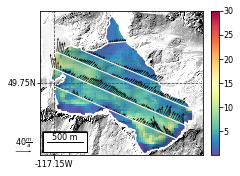

In [283]:
vf_list = ['kokanee_vy_25m_2016.tif','kokanee_vy_25m_2017.tif','kokanee_vy_25m_2018.tif']
vdir = '/home/pelto/Desktop/velocity_mapping/' +glacier[gl] + '/dem/3m/'
ITS = fl_path + 'ITS_Live/' + str(year) + '_conrad_ITS_LIVE.tif'

year=2016
I = np.abs(year - 2016) 

VX = vdir+ vf_list[I][:-15] + 'vx_25m_' +str(year)+ '.tif' 
VY = vdir+ vf_list[I][:-15] + 'vy_25m_' +str(year)+ '.tif' 

vy = salem.open_xr_dataset(VY);vy = vy.to_array(name='vy')
vx = salem.open_xr_dataset(VX);vx = vx.to_array(name='vx')
msk = salem.open_xr_dataset(path + 'kokanee_2015_extent_5m.tif')
msk_reproj = vy.salem.transform(msk); msk = msk_reproj.to_array(name='msk')
topo ='/home/pelto/Desktop/lidar_cbt_analysis/kokanee/20181014_Kokanee_dem1_clip_slave.tif' 

vz = vy
vz.data = np.sqrt(vx.data**2 + vz.data**2 )
vz.data[vz.data<0.01]=np.nan;# vz.data[vz.data>30.0]=vz.data[vz.data>30.0]*0.5 ##remove high erroneous values
vz.data[msk.data!=1.0] = np.nan;

font = {'family' : 'Helvetica', 'weight' : 'normal', 'size'   : 8}
plt.rc('font', **font)
pylab.rcParams['xtick.major.pad']='1'
pylab.rcParams['ytick.major.pad']='1'

fig, ax = plt.subplots(1, figsize=cm2inch(8.5,5.75))
grid = mercator_grid(center_ll=(-117.137, 49.75), extent=(2250, 2000)) ##zoomed out view
sm1 = Map(grid, countries=False)
sm1.set_lonlat_contours(interval=0)
sm1.set_scale_bar(location=(0.15, 0.09),add_bbox=True,bbox_dy=1.1,linewidth=1.0)

VZA=xr.DataArray(data=vz, coords=vz.coords, dims=vz.dims, name='VZA', attrs=vz.attrs) #,indexes=vx.indexes fastpath=False)

# VZA.data=VZA.data*(msk+1.0)
sm1.set_data(VZA) 

sm1.set_cmap("Spectral_r")
sm1.set_vmax(val=30.)
#      Change the lon-lat countour setting
sm1.set_lonlat_contours(add_ytick_labels=True, interval=0.05, linewidths=0.75, linestyles='--', colors='0.25')
sm1.set_topography(topo,  relief_factor=0.8)
sm1.set_shapefile(shpf, lw=1.5, color='w')
sm1.set_shapefile(gates, color='w', lw=1.1)
sm1.append_colorbar(ax=ax, pad=0.1, label='')#'Ice Velocity (m yr$^{-1}$)')
sm1.plot(ax=ax)

u = df_agg.vx.values
v = df_agg.vy.values;v[v>25]=v[v>25]*0.5

X, Y = np.meshgrid(df_agg.lon,df_agg.lat)

# transform their coordinates to the map reference system and plot the arrows
xx, yy = sm1.grid.transform(df_agg.lon, df_agg.lat, crs=salem.wgs84)#sm1.grid.proj

# xx, yy = np.meshgrid(xx,yy)

# qu = ax.quiver(xx, yy, u, v)

###### start:stop:step
Q = ax.quiver(xx[::1], yy[::1], u[::1], v[::1])  #, pivot='mid')
qk = ax.quiverkey(Q, 0.07, 0.10, 20, r'$40 \frac{m}{a}$', labelpos='N', coordinates='figure', labelsep=0.025)



# Q = ax.quiver(X[::1, ::1], Y[::1, ::1], u[::1, ::1], v[::1, ::1], pivot='mid')
#Q= ax2.quiver(X[::3, ::3], Y[::3, ::3], U[::3, ::3], V[::3, ::3],pivot='mid', units='inches')

# X, Y = np.meshgrid(df_agg.lon,df_agg.lat)
# U = df_agg.vx.values
# V = df_agg.vy.values
# U,V = np.meshgrid(U, V)

# # Q = ax.quiver(X, Y, U, V)#units='width', angles='uv') 
# Q = ax.quiver(X[::30, ::30], Y[::30, ::30], U[::30, ::30], V[::30, ::30], units='xy')


fig.subplots_adjust(bottom=0.05, top=0.99, left=0.14, right=0.88) #, wspace=0.22, hspace=0.15
plt.savefig(fl_path+ 'products/'+ glacier[gl]+ '_' +str(year) +'_vel_gates_quiver.pdf', dpi=300)